<a href="https://www.kaggle.com/code/m000sey/multi-class-w-boosts-eda-dim-reduction?scriptVersionId=155192388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
### Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import catboost, xgboost, lightgbm
from scipy.stats import yeojohnson
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import HuberRegressor
from sklearn.compose import TransformedTargetRegressor
import sklearn.cluster as skc 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time, optuna, warnings, os, platform, time, random, gc, itertools, re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import missingno
from sklearn.impute import SimpleImputer
print("Libraries imported...")

Libraries imported...


In [2]:
### Load the data
PATH = '/kaggle/input/playground-series-s3e26/'
train = pd.read_csv(os.path.join(PATH,'train.csv'), index_col='id')
test = pd.read_csv(os.path.join(PATH,'test.csv'), index_col='id')
sub = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
ORIG_PATH = '/kaggle/input/cirrhosis-patient-survival-prediction'
original = pd.read_csv(os.path.join(ORIG_PATH,'cirrhosis.csv'), index_col='ID')
print("Data loaded...")

# Define some important variables
SEED = 42
FOLD = 10
SKF = RepeatedStratifiedKFold(n_splits=FOLD, n_repeats=1, random_state=SEED)

# Remap categorical columns
CAT_COLS = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
NUM_COLS = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
TIME_COLS = ['Age', 'N_Days', 'prop_days']

COLS = CAT_COLS + NUM_COLS + TIME_COLS

Data loaded...


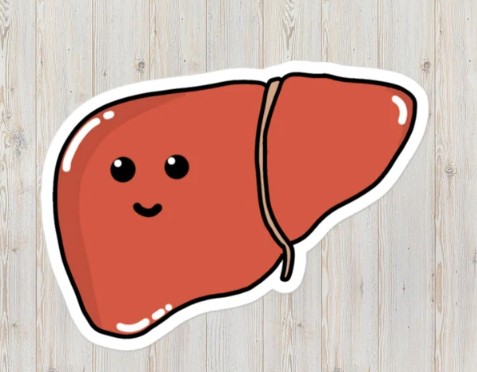

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Understanding the question</span>
- We have a multi-class classification task at hand with log loss being our evaluation metric
    - Logloss is a pretty standard evaluation metric for classification problems
    - Logloss is very closesly related to the likelihood function
    - Lower scores mean better model performance
    - Here's a cool post to understand more about logloss https://www.kaggle.com/code/dansbecker/what-is-log-loss
- Our task is to predict patient outcomes based on clinical features
    - The dataset belongs to the Mayo Clinic and is from a study from the 70s and 80s
    - The three main categories are alive, dead, and liver transplant

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">TO DO</span>
- retry another robust optuna algo with a good CV
- Try more features esp arithmetic sums
- Try random forest to see what features it likes to get some feature importances

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Data cleaning</span>


<Axes: >

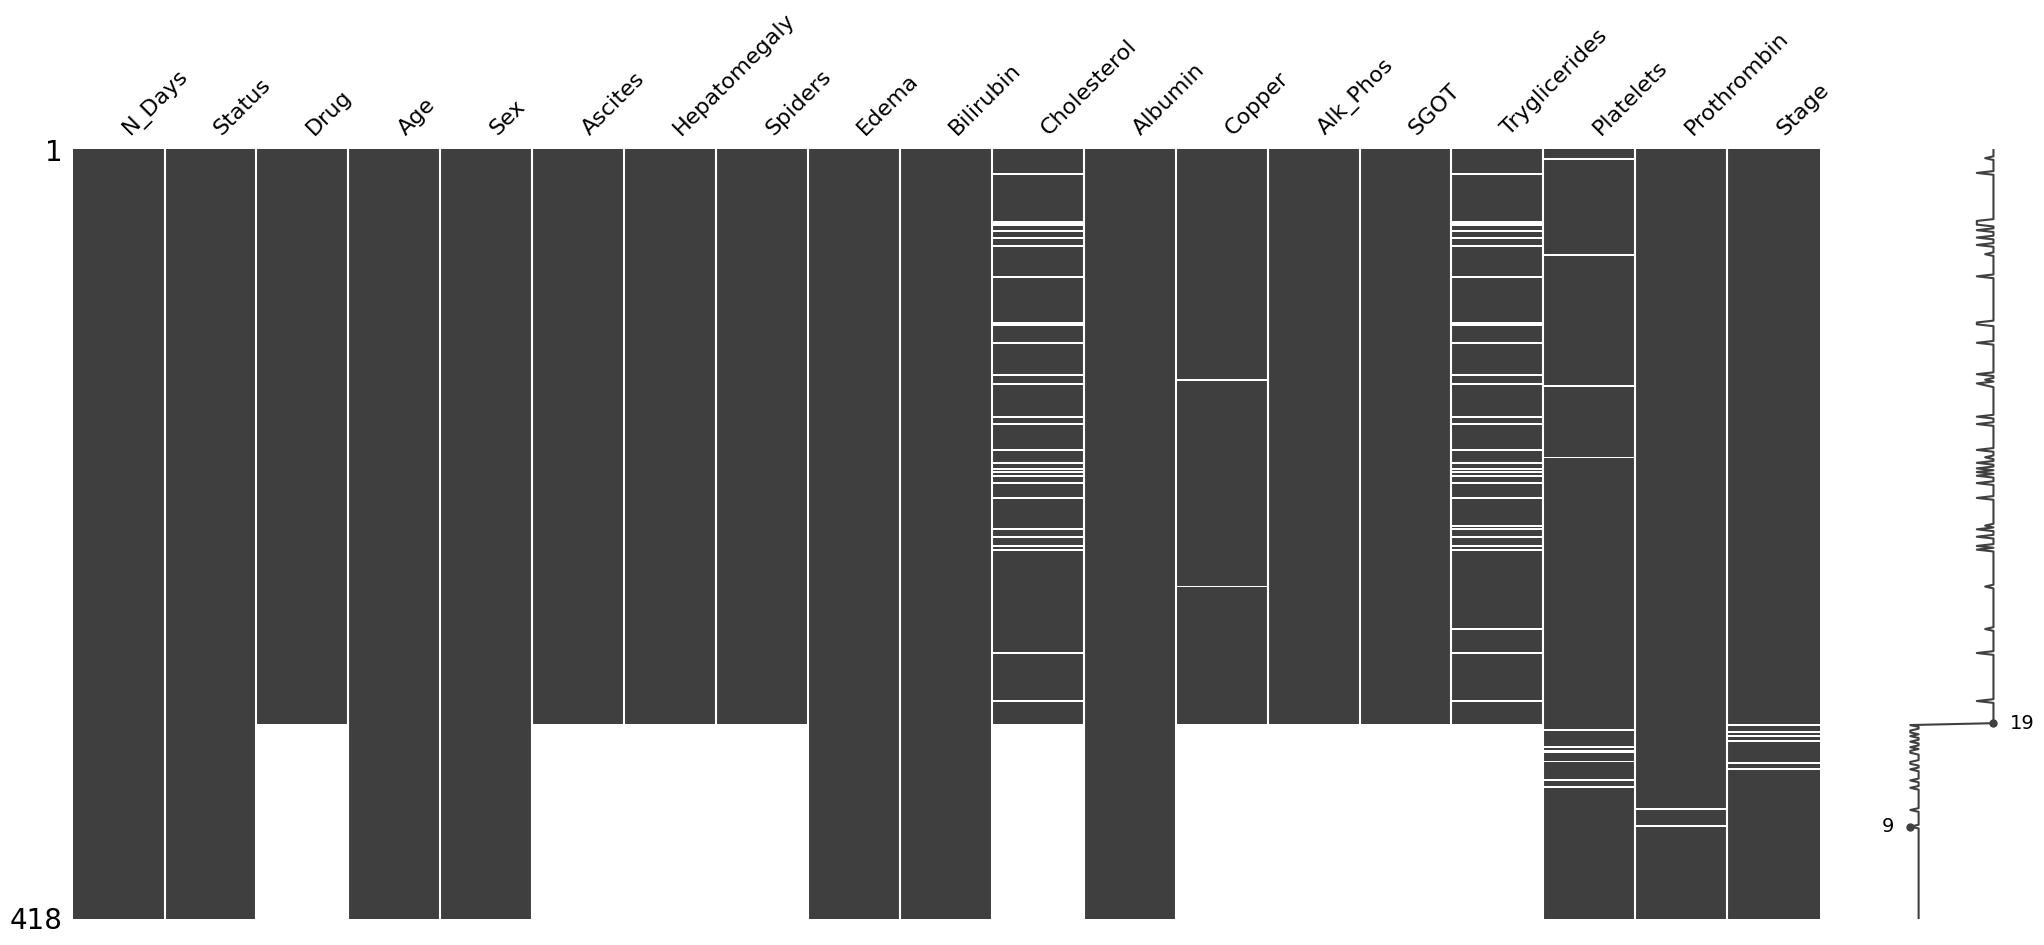

In [3]:
# Observe the missing values in the original dataset
missingno.matrix(original)

💡 **insights:** 💡
- As you can see with the missingno graph, after id == 312, there're too many missing values. Let's drop those.
- Adding the original data with my imputation regime improved my CV and public score.

In [4]:
original = original.loc[original.index <= 312] 
# Concatenate train with original data
train = pd.concat([train, original], axis=0)

In [5]:
train['Status'] = train['Status'].map({'C': 0, 'D': 2, 'CL': 1})
# Reampper
def remapper(df):
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    df['Ascites'] = df['Ascites'].map({'Y': 1, 'N': 0})
    df['Hepatomegaly'] = df['Hepatomegaly'].map({'Y': 1, 'N': 0})
    df['Spiders'] = df['Spiders'].map({'Y': 1, 'N': 0})
    df['Edema'] = df['Edema'].map({'Y': 2, 'S': 1, 'N': 0})
    df['Drug'] = df['Drug'].map({'D-penicillamine': 1, 'Placebo': 0})
    
remapper(train)
remapper(test)
print("Remapping complete...")

# Feature engineering
def feature_engineer(df):
    # Create new features
    df['prop_days'] = (df['Age'] / df['N_Days']).astype(int)
    # df['prop_days'] = np.log1p(df['prop_days'])
    
    # From Yang Zhou's notebook
    # df['diseases'] = df['Ascites'] + df['Hepatomegaly'] + df['Spiders'] + df['Edema'] 
feature_engineer(train)
feature_engineer(test)
print("Feature engineering complete...")

X = train.drop('Status', axis=1)
y = train['Status']
z = test

Remapping complete...
Feature engineering complete...


💡 **insights:** 💡
- I want to explore with some other features
- Yang Zhou's (the recently minted master) feature improved my CV, but not my public leaderboard. It might be worth while to combine different stages of edma to one

In [6]:
# Impute missing values from original after concatenation
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Reset indices of X and y
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X_plus_y = pd.concat([X, y], axis=1)
print("Imputation complete...")

Imputation complete...


💡 **insights:** 💡
- So far, I've only done basic imputing, but there has to be a more sophisticated way to deal with the missing values.
- In the near future, I plan to try to explore how to impute based on hardcoding observed trends.

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Univariate Data Explorationn</span>

In [7]:
# EDA
X.describe().T

count          mean          std      min       25%       50%  \
N_Days         8217.0   2029.269198  1095.290219    41.00   1230.00   1832.00   
Drug           8217.0      0.493246     0.499985     0.00      0.00      0.00   
Age            8217.0  18369.208835  3686.954249  9598.00  15574.00  18701.00   
Sex            8217.0      0.073628     0.261180     0.00      0.00      0.00   
Ascites        8217.0      0.049166     0.216228     0.00      0.00      0.00   
Hepatomegaly   8217.0      0.511379     0.499901     0.00      0.00      1.00   
Spiders        8217.0      0.246927     0.431250     0.00      0.00      0.00   
Edema          8217.0      0.140927     0.458184     0.00      0.00      0.00   
Bilirubin      8217.0      2.619606     3.844404     0.30      0.70      1.10   
Cholesterol    8217.0    351.041134   196.463228   120.00    248.00    299.00   
Albumin        8217.0      3.547247     0.349266     1.96      3.35      3.58   
Copper         8217.0     84.416332    76.318921     4.00     39.00     63.00   
Alk_Phos       8217.0   1823.044883  1913.388685   289.00    834.00   1181.00   
SGOT           8217.0    114.906530    49.134067    26.35     75.95    108.50   
Tryglicerides  8217.0    115.620056    52.945414    33.00     84.00    104.00   
Platelets      8217.0    265.105391    87.759152    62.00    210.00    265.00   
Prothrombin    8217.0     10.633114     0.791468     9.00     10.00     10.60   
Stage          8217.0      3.032494     0.866891     1.00      2.00      3.00   
prop_days      8217.0     17.836193    40.195199     2.00      6.00      9.00   

                    75%       max  
N_Days          2689.00   4795.00  
Drug               1.00      1.00  
Age            20684.00  28650.00  
Sex                0.00      1.00  
Ascites            0.00      1.00  
Hepatomegaly       1.00      1.00  
Spiders            0.00      1.00  
Edema              0.00      2.00  
Bilirubin          3.00     28.00  
Cholesterol      390.00   1775.00  
Albumin            3.77      4.64  
Copper           102.00    588.00  
Alk_Phos        1857.00  13862.40  
SGOT             137.95    457.25  
Tryglicerides    139.00    598.00  
Platelets        316.00    563.00  
Prothrombin       11.00     18.00  
Stage              4.00      4.00  
prop_days         15.00    628.00

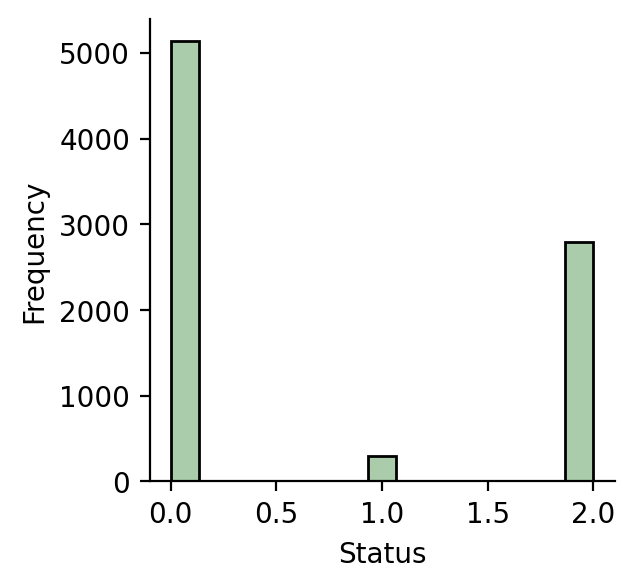

In [8]:
# Target distribution (train)
plt.figure(figsize=(3, 3), dpi=200)
sns.histplot(train['Status'], color='darkseagreen', edgecolor='black')
sns.despine(top=True, right=True)
sns.set(style="whitegrid", font='Arial')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.show()

💡 **insights:** 💡
- As you can see, the multi-class target is very imbalanced. The best models out there, will be good at classifying CL

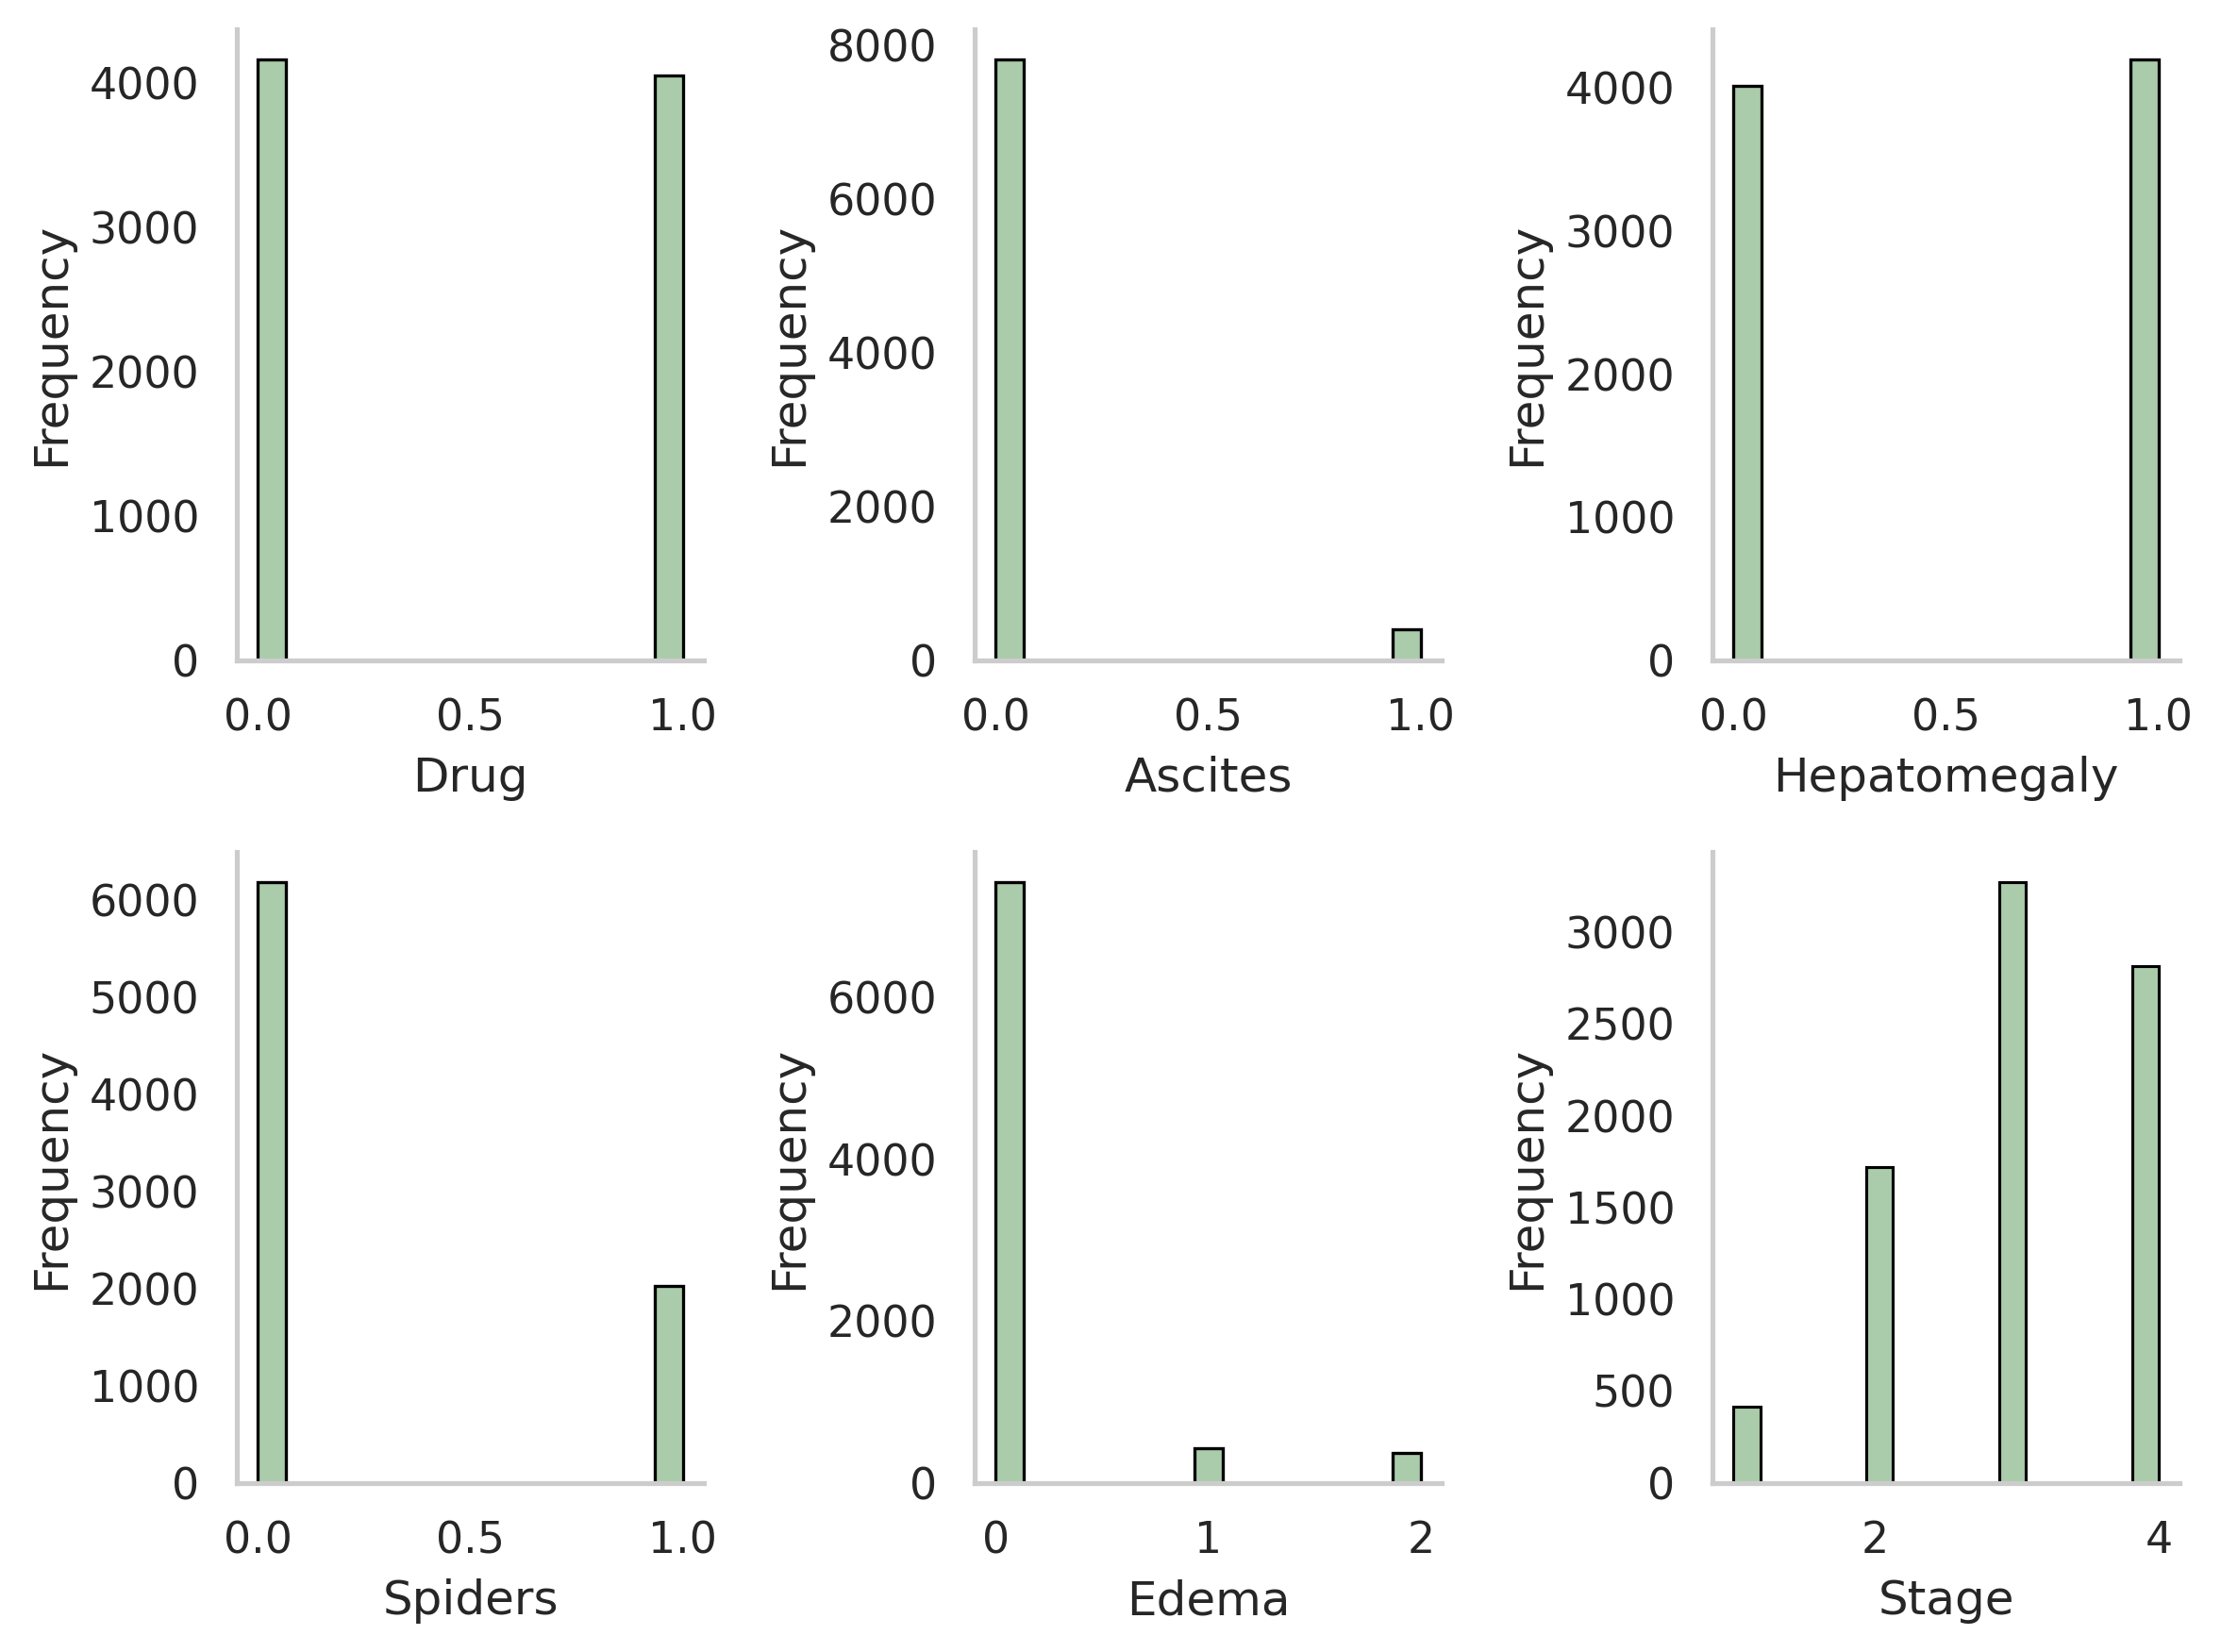

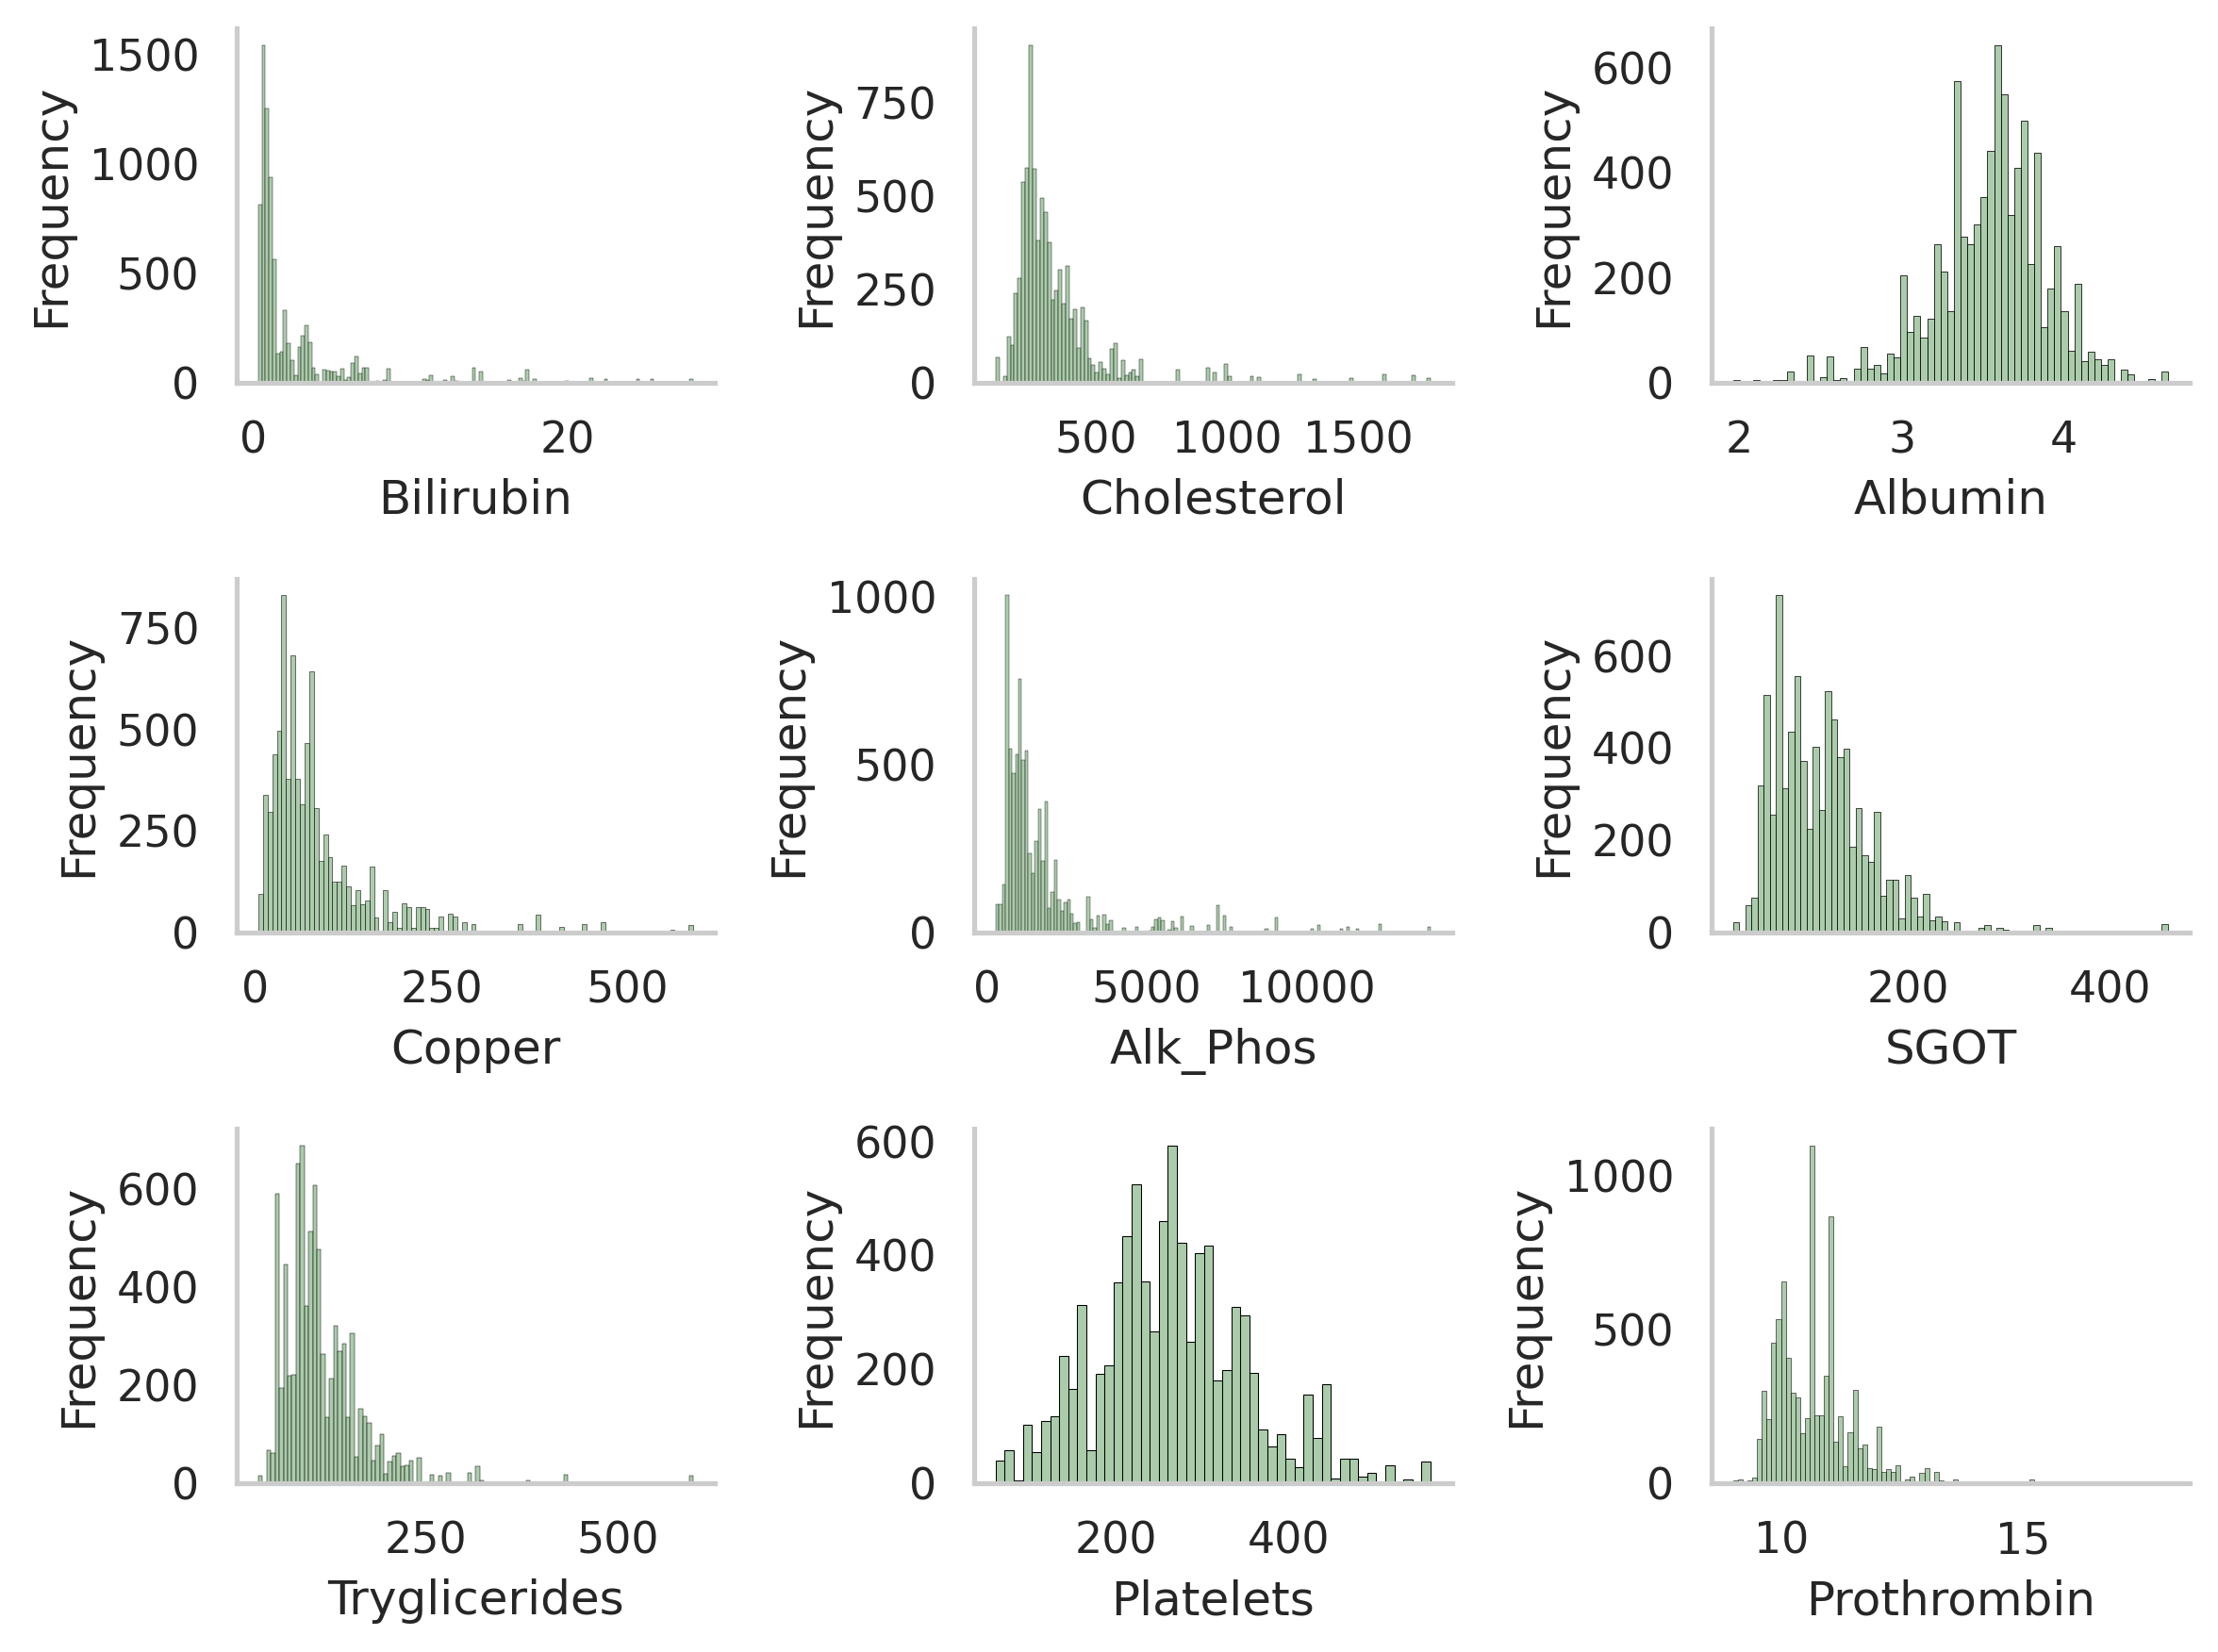

In [9]:
# Plotting the histograms of the categorical variables.
def plot_hist(data, columns, row):
    sns.set(style="whitegrid", font='Arial')
    fig, axes = plt.subplots(row, 3, figsize=(8, 6), dpi=300)

    for i, column in enumerate(columns):
        ax_histo = axes[i // 3, i % 3]

        ax_histo = sns.histplot(data[column], kde=False, color='darkseagreen', ax=ax_histo, edgecolor='black')
        ax_histo.set_xlabel(column)
        ax_histo.set_ylabel("Frequency")
        ax_histo.spines['top'].set_visible(False)
        ax_histo.spines['right'].set_visible(False)
        ax_histo.grid(visible=False)

    plt.tight_layout()
    plt.show()
    
plot_hist(X[CAT_COLS], CAT_COLS, 2)
plot_hist(X[NUM_COLS], NUM_COLS, 3)

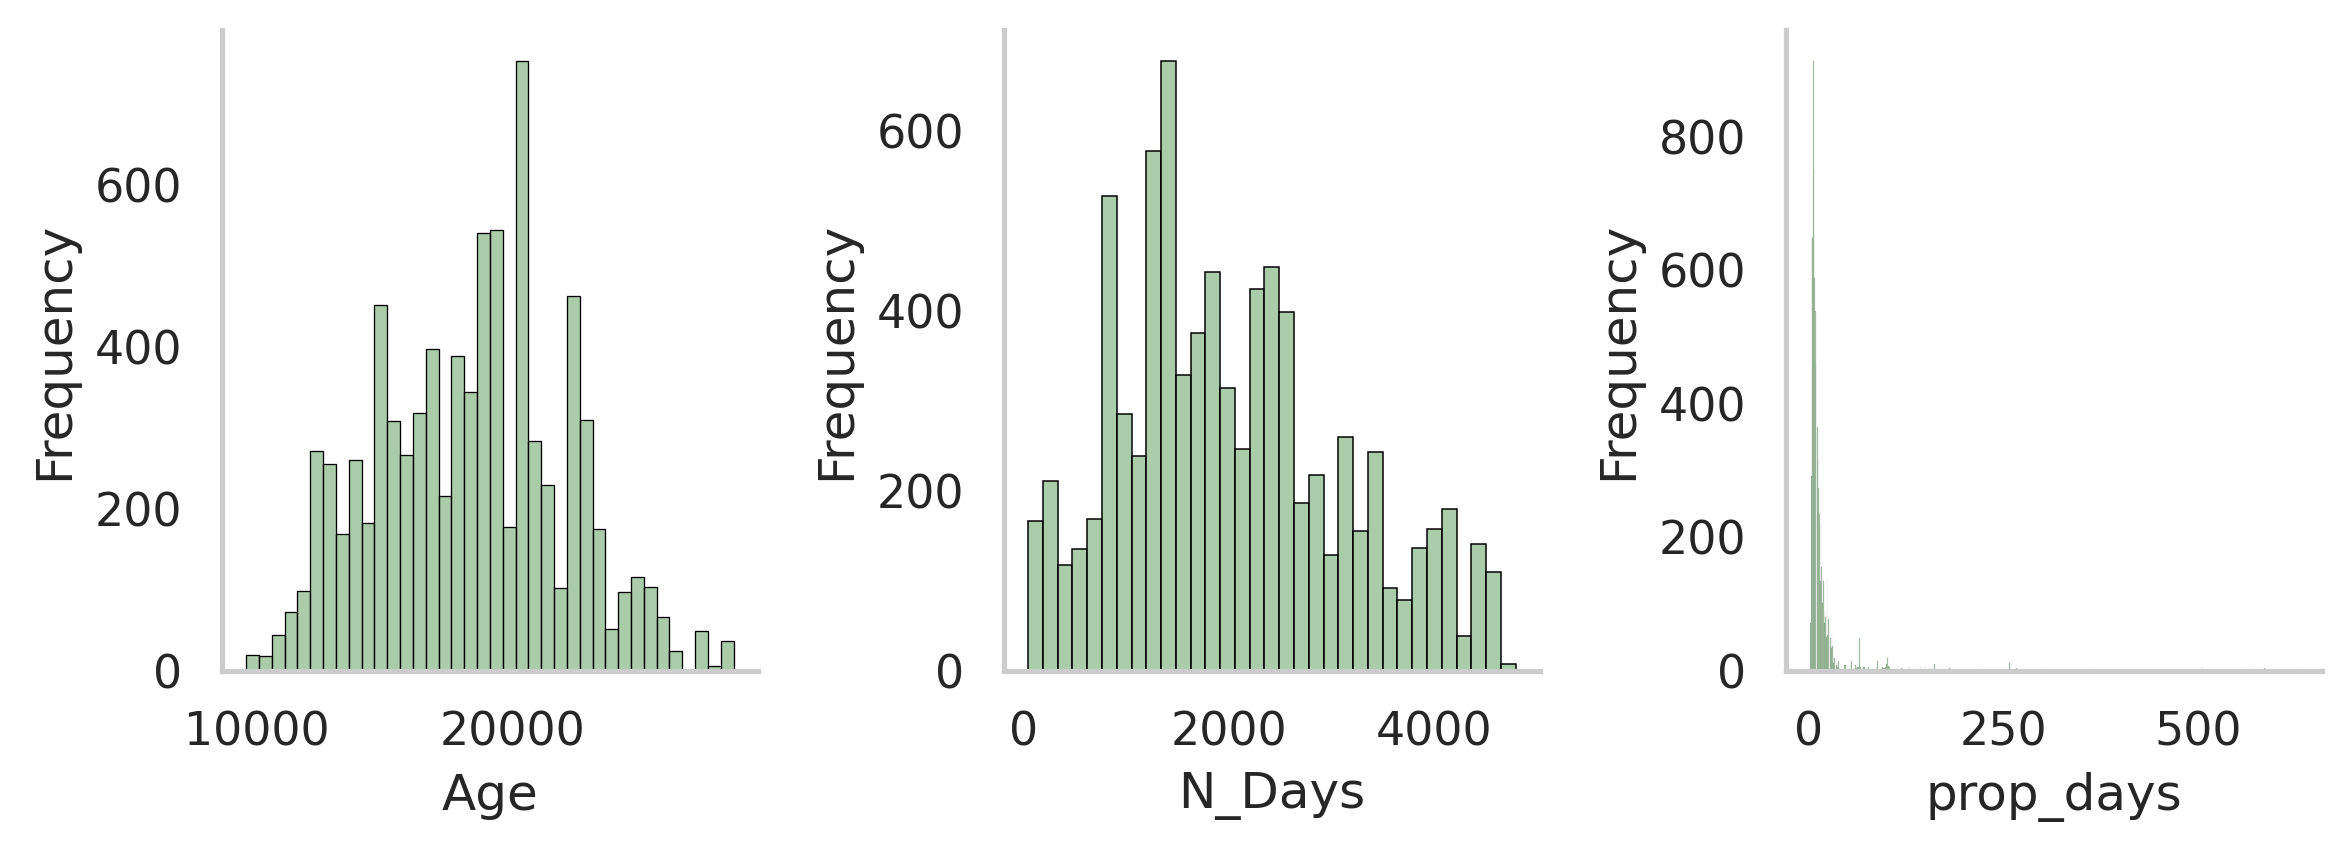

In [10]:
def plot_hist_days(data, columns):
    sns.set(style="whitegrid", font='Arial')
    fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=300)

    for i, column in enumerate(columns[:3]):  # Take the first 3 columns
        ax_histo = axes[i]

        ax_histo = sns.histplot(data[column], kde=False, color='darkseagreen', ax=ax_histo, edgecolor='black')
        ax_histo.set_xlabel(column)
        ax_histo.set_ylabel("Frequency")
        ax_histo.spines['top'].set_visible(False)
        ax_histo.spines['right'].set_visible(False)
        ax_histo.grid(visible=False)

    plt.tight_layout()
    plt.show()
    
plot_hist_days(X[TIME_COLS], TIME_COLS)

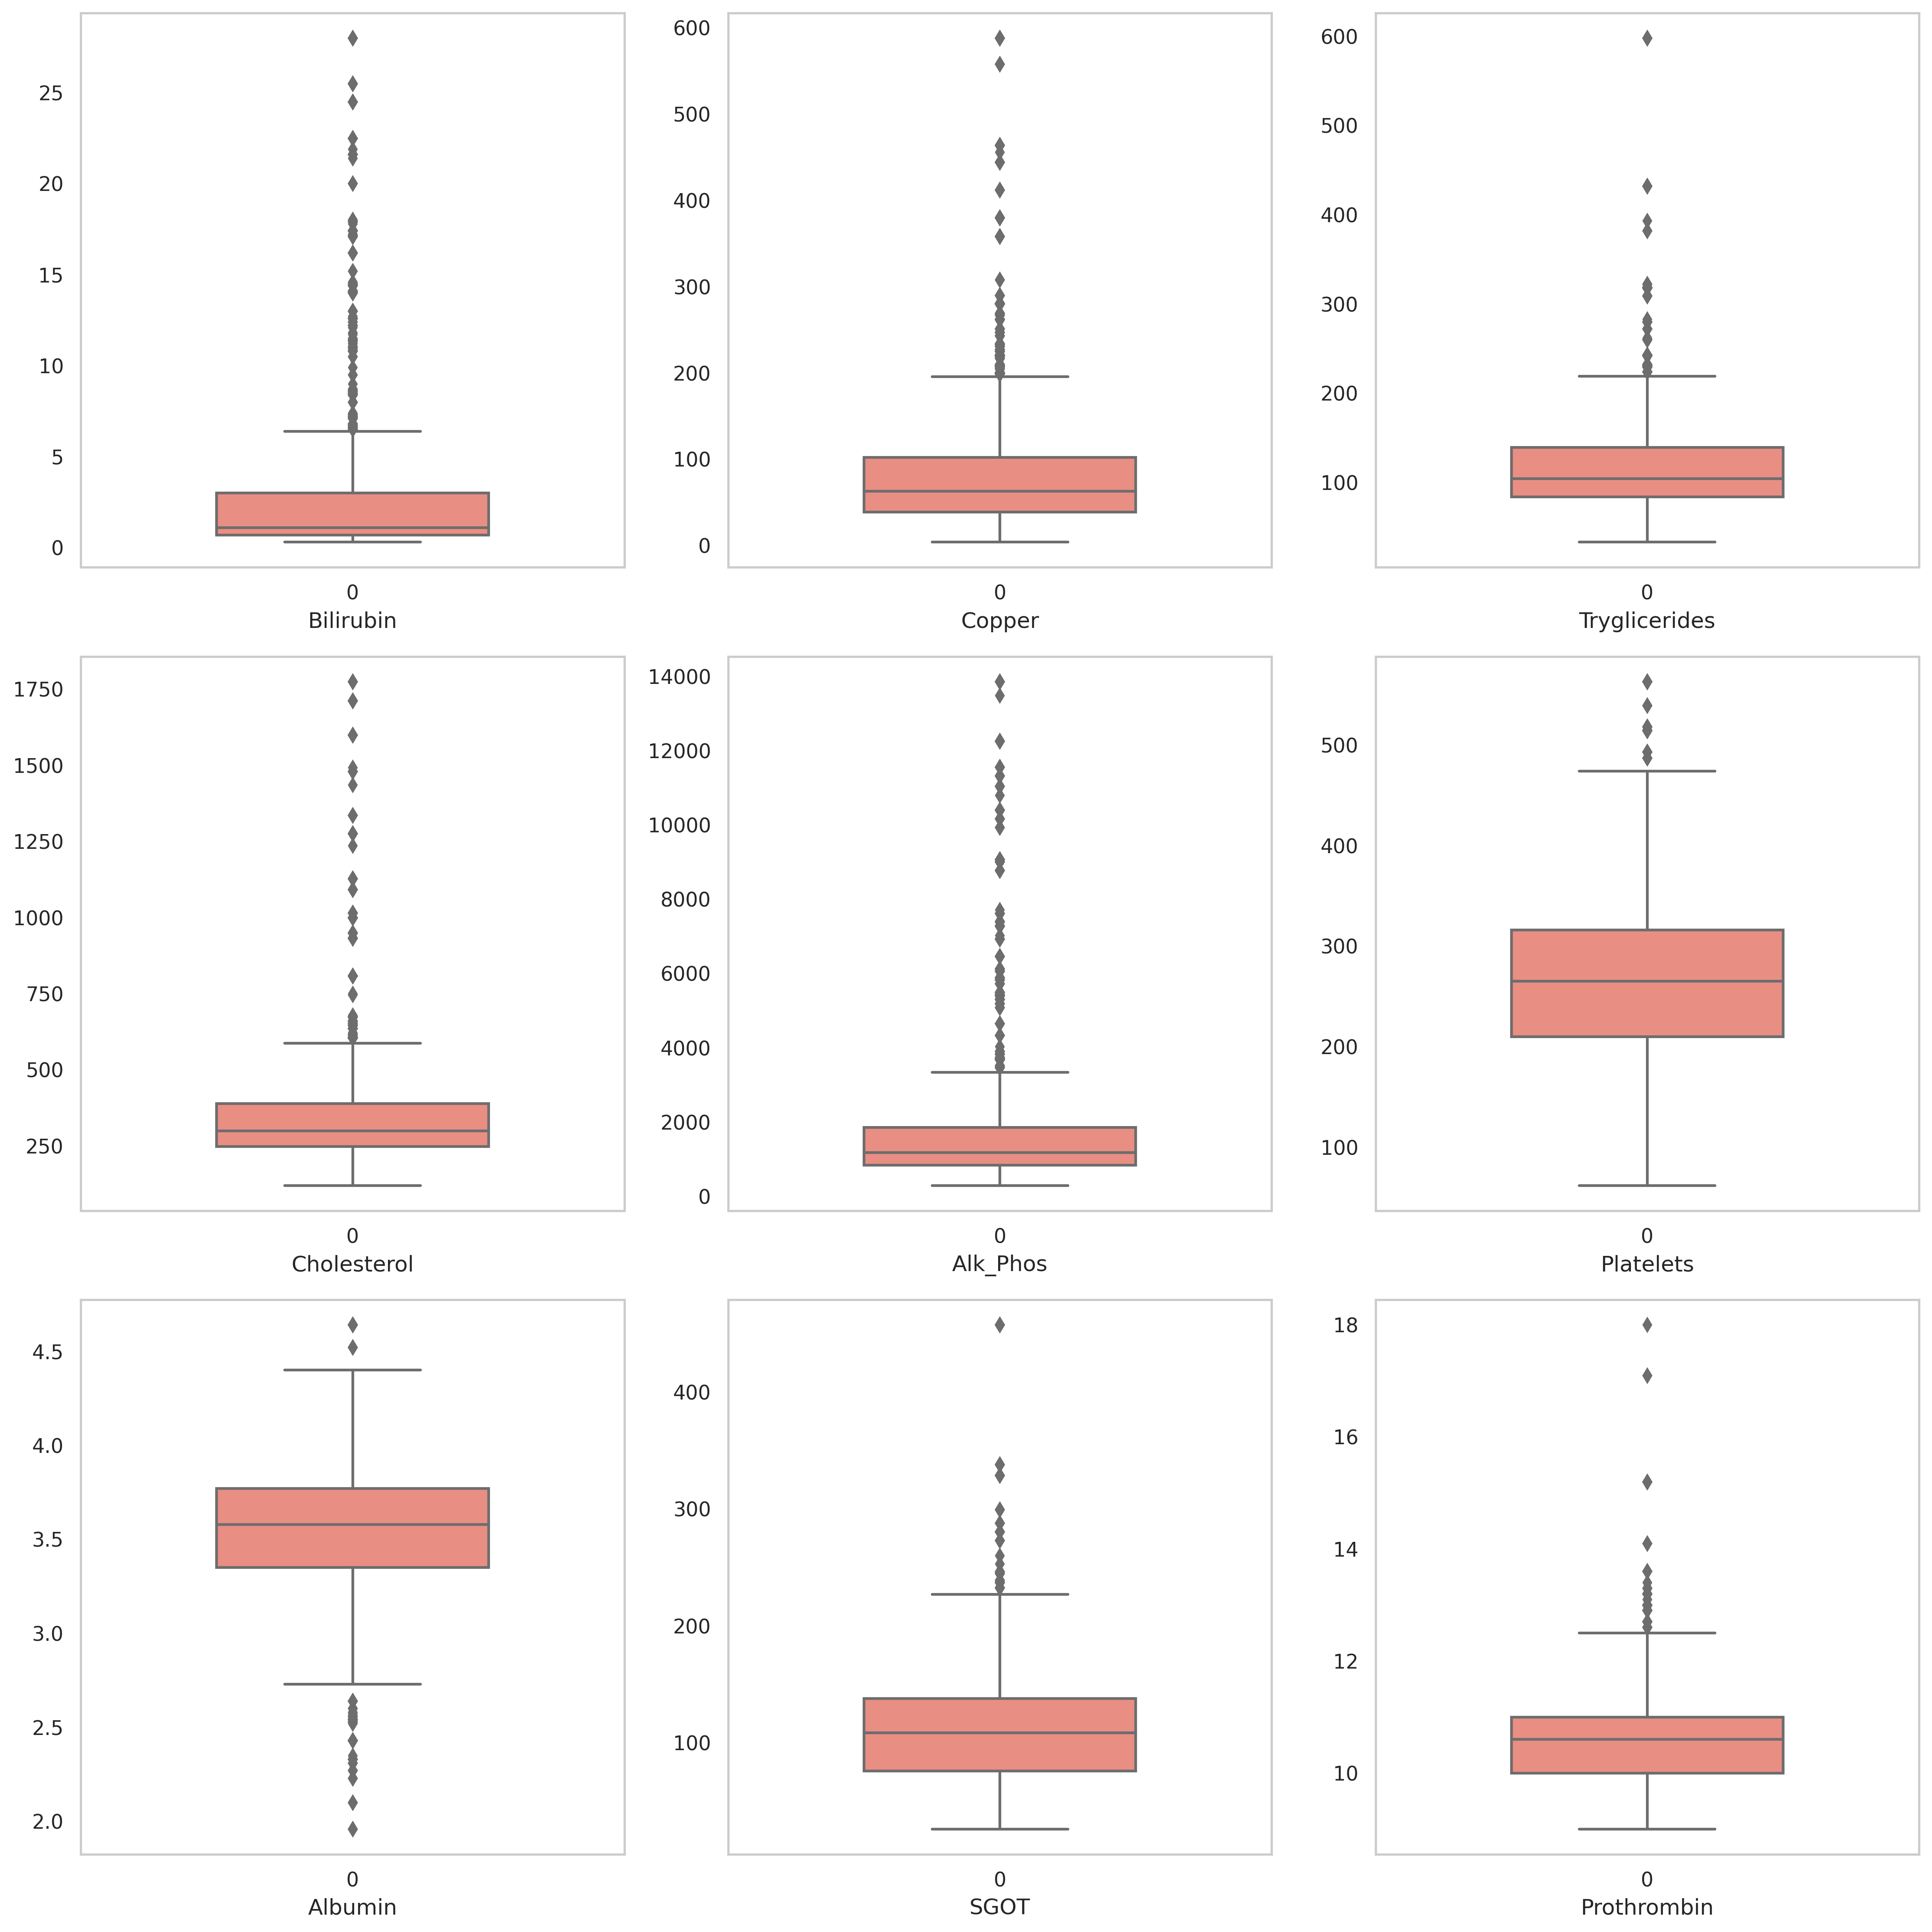

In [11]:
def plot_box(data):
    sns.set(style="whitegrid", font='Arial')
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)

    for i, column in enumerate(NUM_COLS):
        ax_box = axes[i % 3, i // 3]

        sns.boxplot(data=data[column], color='salmon', width=0.5, ax=ax_box)
        ax_box.set_xlabel(column)
        ax_box.set_ylabel("")
        ax_box.grid(visible=False)

    plt.tight_layout()
    plt.show()
    
plot_box(X[NUM_COLS])

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Dimensionality reduction techniques</span>

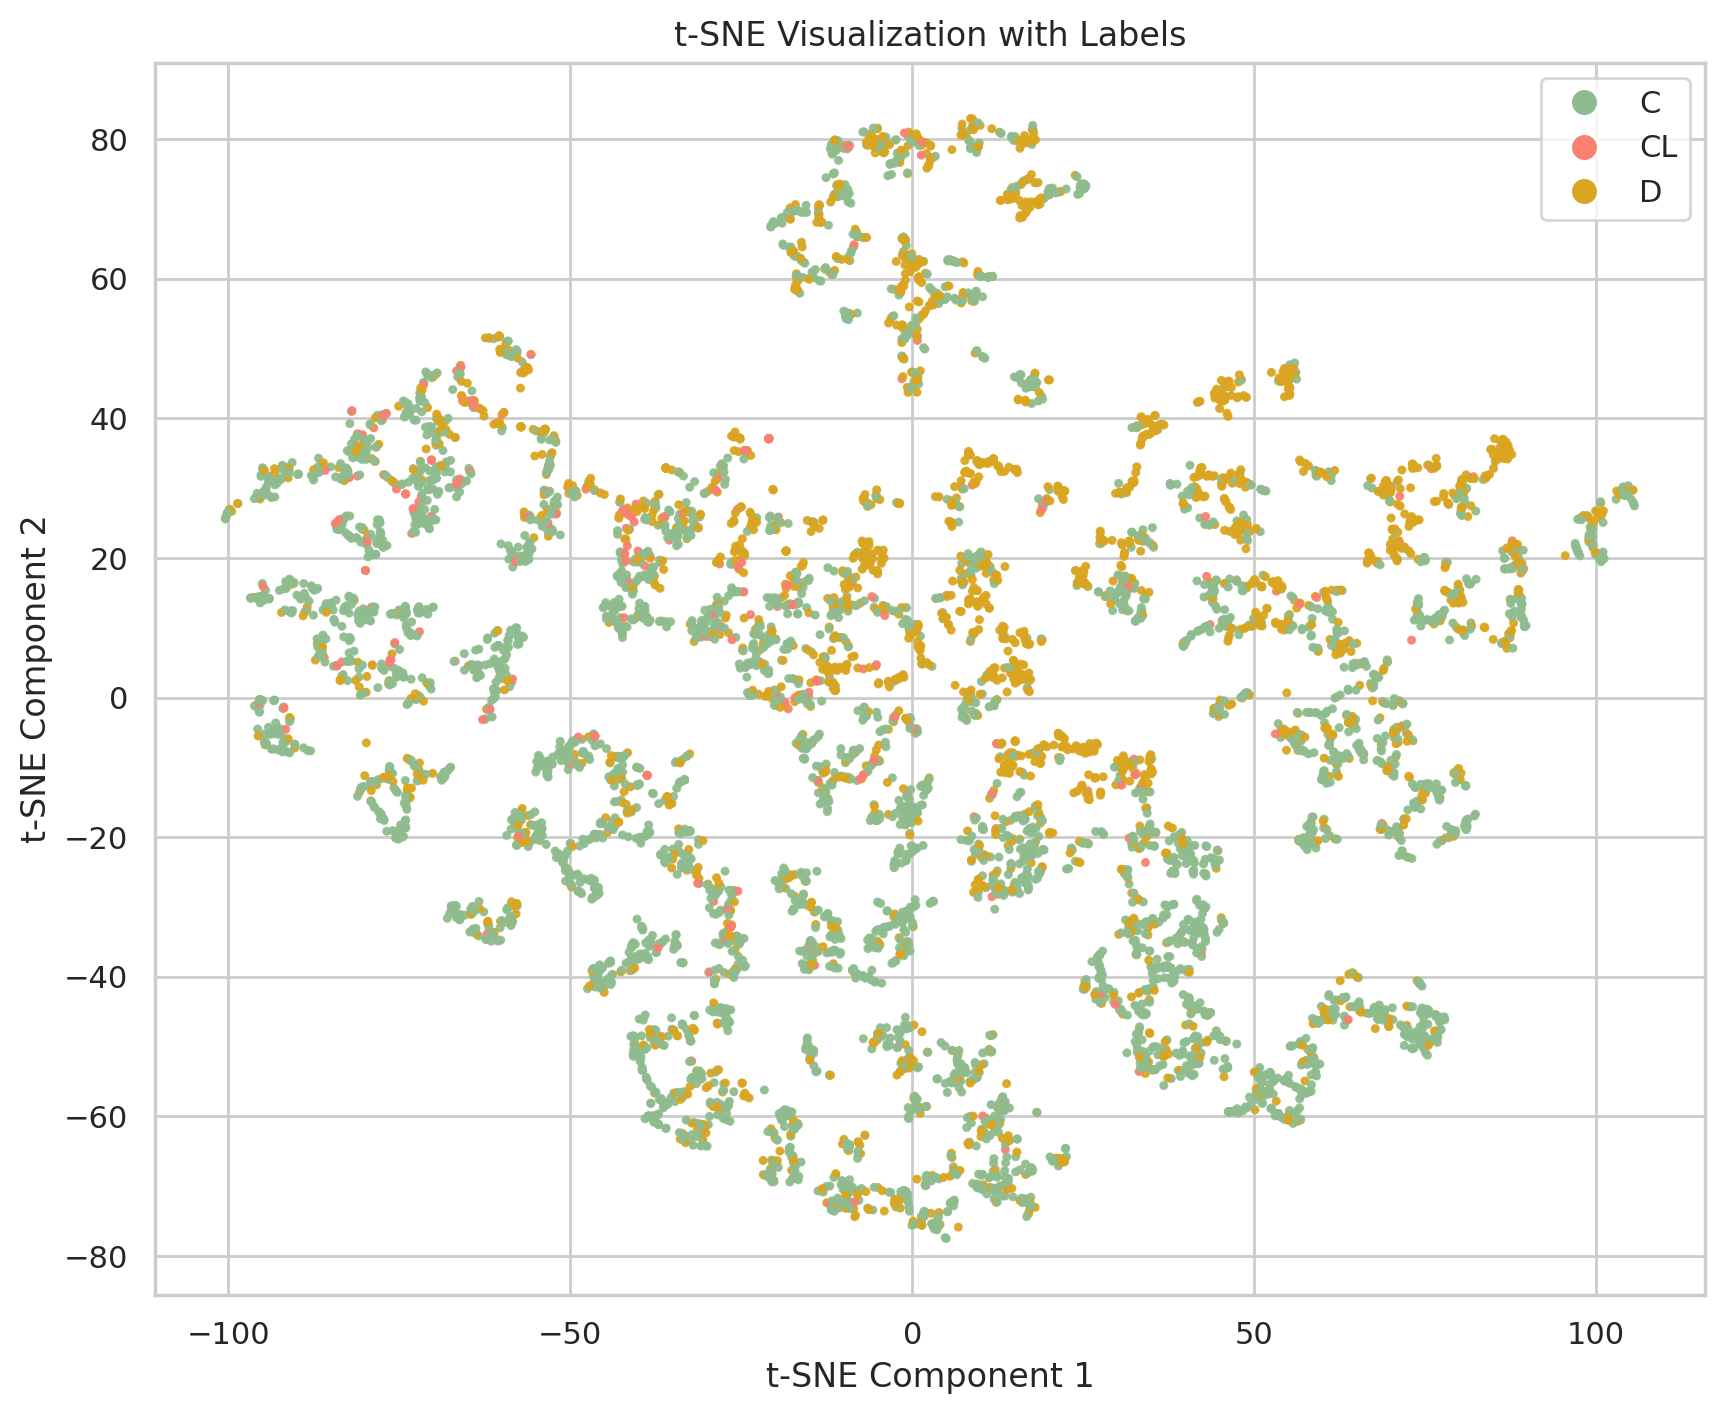

In [12]:
# Conduct t-sne dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED)
X_tsne = tsne.fit_transform(X)

# Plot the t-sne
custom_palette = ['darkseagreen', 'salmon', 'goldenrod']
plt.figure(figsize=(10, 8), dpi=200)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[custom_palette[label] for label in y], alpha=0.9, s=5) 

# Create a legend
legend_labels = ['C', 'CL', 'D']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[i], markersize=10) for i in range(len(custom_palette))]
plt.legend(legend_handles, legend_labels, loc='upper right')

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

💡 **insights:** 💡
- I see some overall trends here, but nothing super appealing to chase after.
- I find it interesting that the liver transplate folks seem to be mostly between the living and dead states.

Explained Variance: [0.22507062 0.09295505 0.06876997 0.06007292 0.05412393 0.05211516
 0.04791539 0.04524889 0.04282178 0.04205028 0.04120533 0.03751859
 0.03533661 0.03231964 0.02906216 0.02615895 0.02447374 0.02407917
 0.01870182]


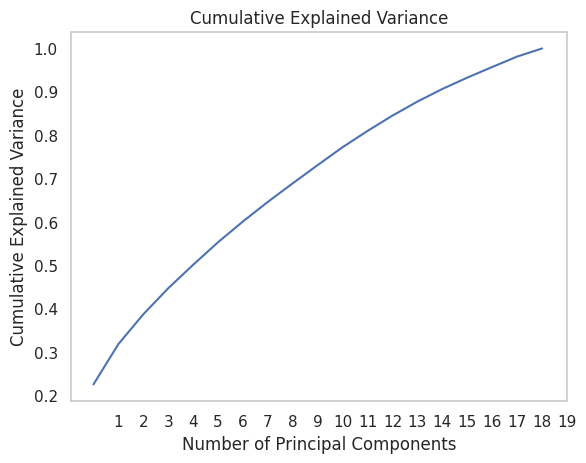

Number of Components to Retain: 19


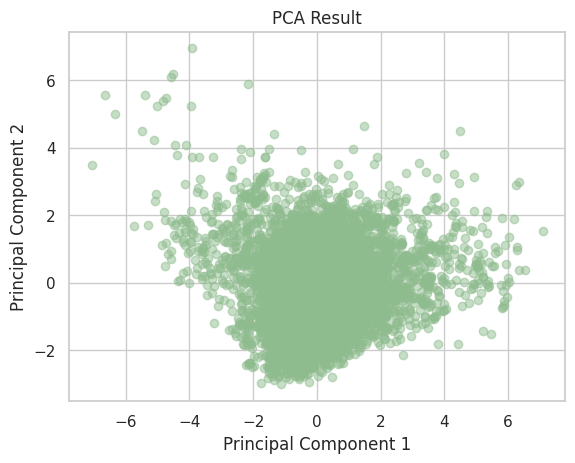

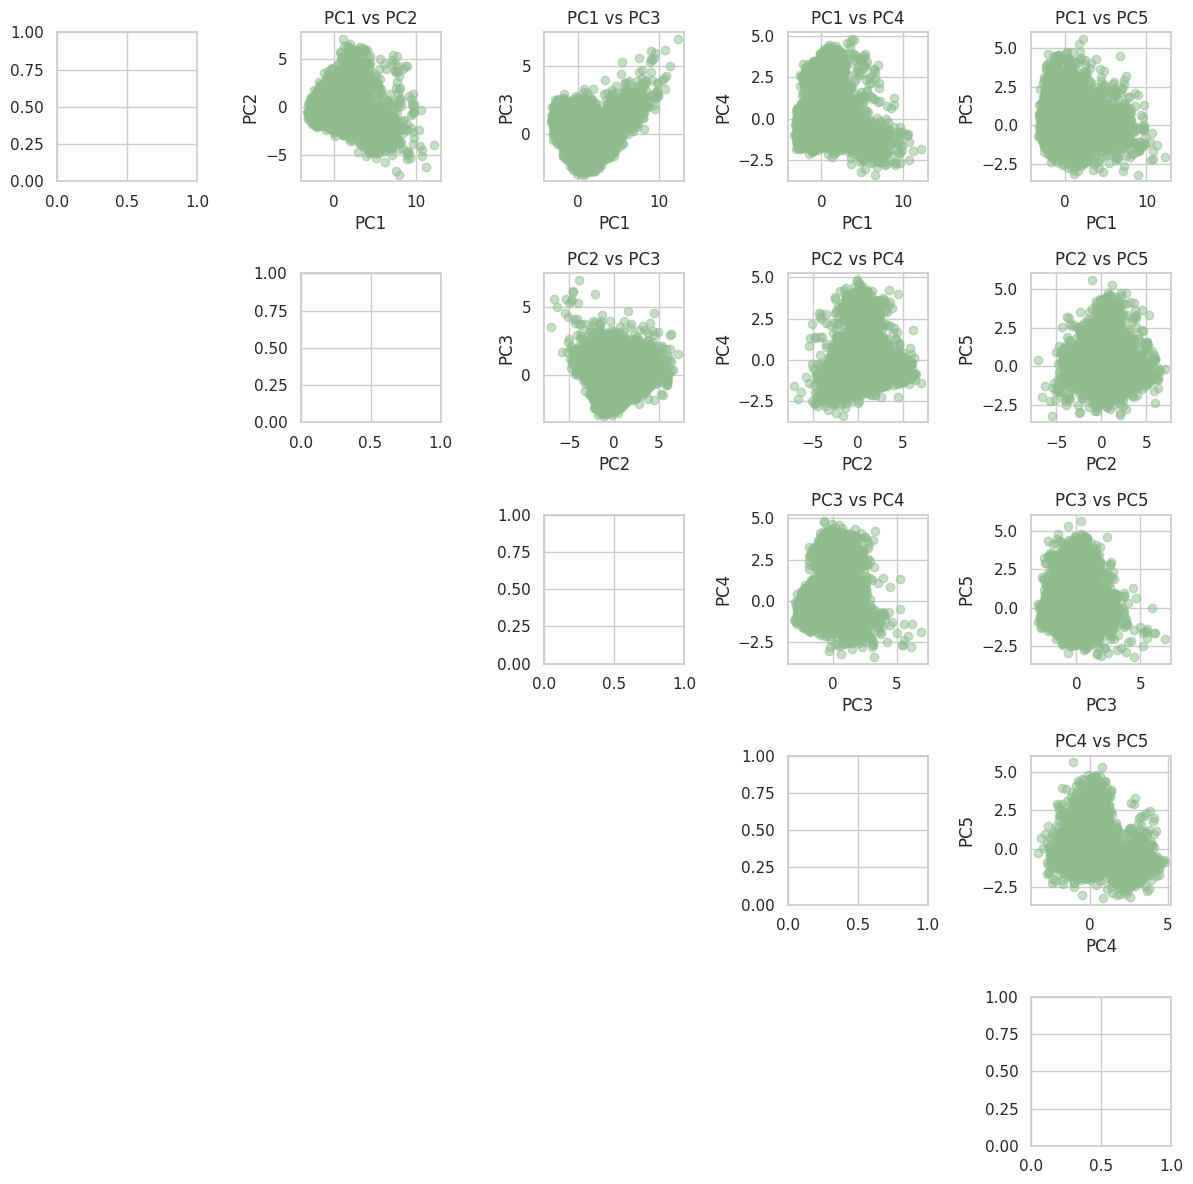

In [13]:
# Scale data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Calculate principal components
principal_components = PCA(n_components=19).fit(X_scaled)

# Plot the cumulative distribution of principal component to variance of dataset
explained_variance = principal_components.explained_variance_ratio_
print("Explained Variance:", explained_variance)

cumulative_explained_variance = np.cumsum(principal_components.explained_variance_ratio_)
plt.plot(cumulative_explained_variance)
plt.grid(False)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_explained_variance) + 1))
plt.show()

# Retaining components that explain 95% of the variance
cumulative_explained_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_explained_variance >= 0.99999) + 1 
print("Number of Components to Retain:", num_components)

X_pca = principal_components.transform(X_scaled)[:, :num_components]

def plot_pca(pc1, pc2):
    pc1 = pc1 - 1
    pc2 = pc2 - 1
    plt.scatter(X_pca[:, pc1], X_pca[:, pc2], c='darkseagreen', alpha=0.5)
    plt.title('PCA Result')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_pca(2, 3)
    
# PCA on the top 5 principal components responsible for most of the variance
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, j in itertools.product(range(5), repeat=2):
    if i != j:
        # Scatter plot for the upper triangle
        if i < j:
            axes[i, j].scatter(X_pca[:, i], X_pca[:, j], c='darkseagreen', alpha=0.5)
            axes[i, j].set_xlabel(f'PC{i+1}')
            axes[i, j].set_ylabel(f'PC{j+1}')
            axes[i, j].set_title(f'PC{i+1} vs PC{j+1}')
        # Set the lower triangle to be transparent
        else:
            axes[i, j].set_visible(False)
            
plt.tight_layout()
plt.show()

💡 **insights:** 💡
- No degree of PCA improved my CV score, which means to me that eliminating any amount of the variation within the data is harmful to the mode
- If you take a look at the cumulative variance plot, the slope is more like Y = X than something more asymptotic, which to me, indicates that each feature is valuable in terms of describing the variance.

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Multivariate Data Exploration</span>

<Figure size 600x300 with 0 Axes>

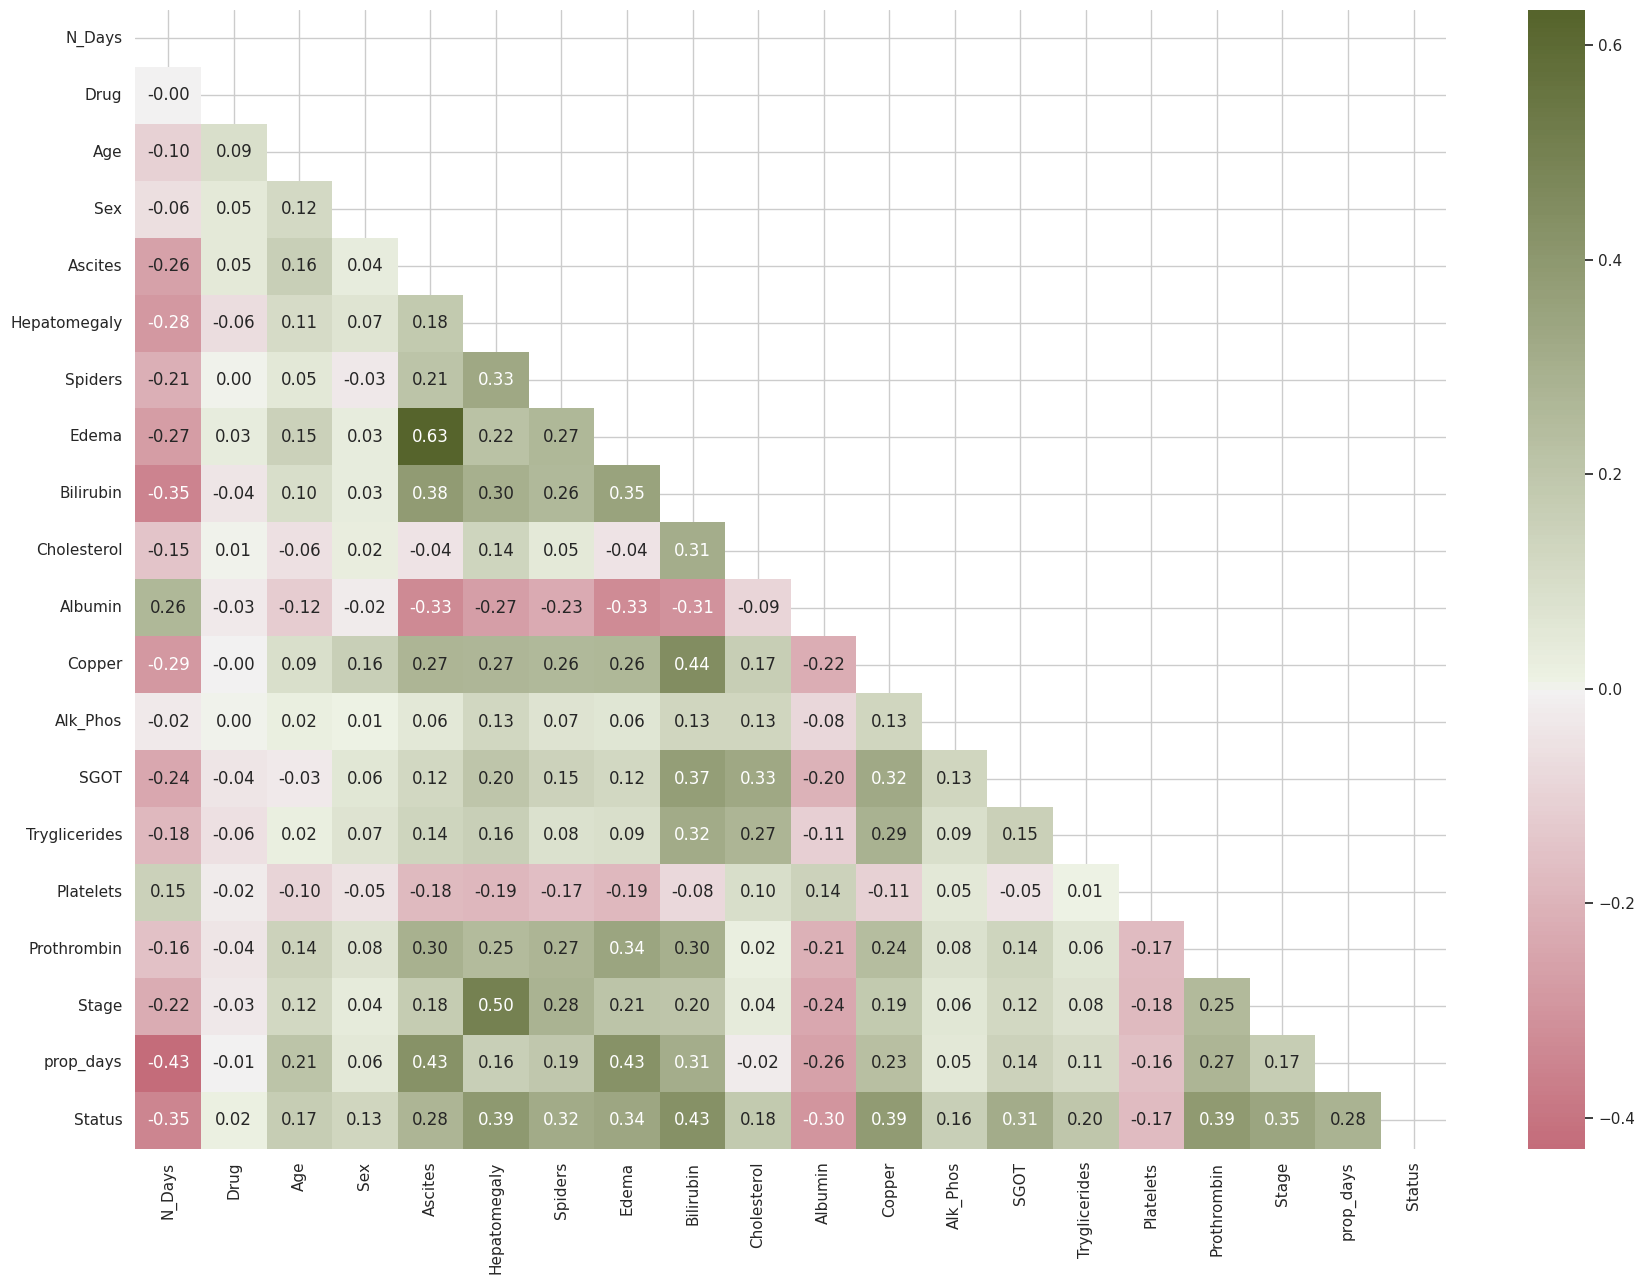

In [14]:
# Correlation matrix
plt.figure(figsize=(6, 3))
corr_mat = X_plus_y.corr()
data_mask = np.triu(np.ones_like(corr_mat, dtype = bool)) 
cmap = sns.diverging_palette(7, 100, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask)
plt.tight_layout()
plt.show()

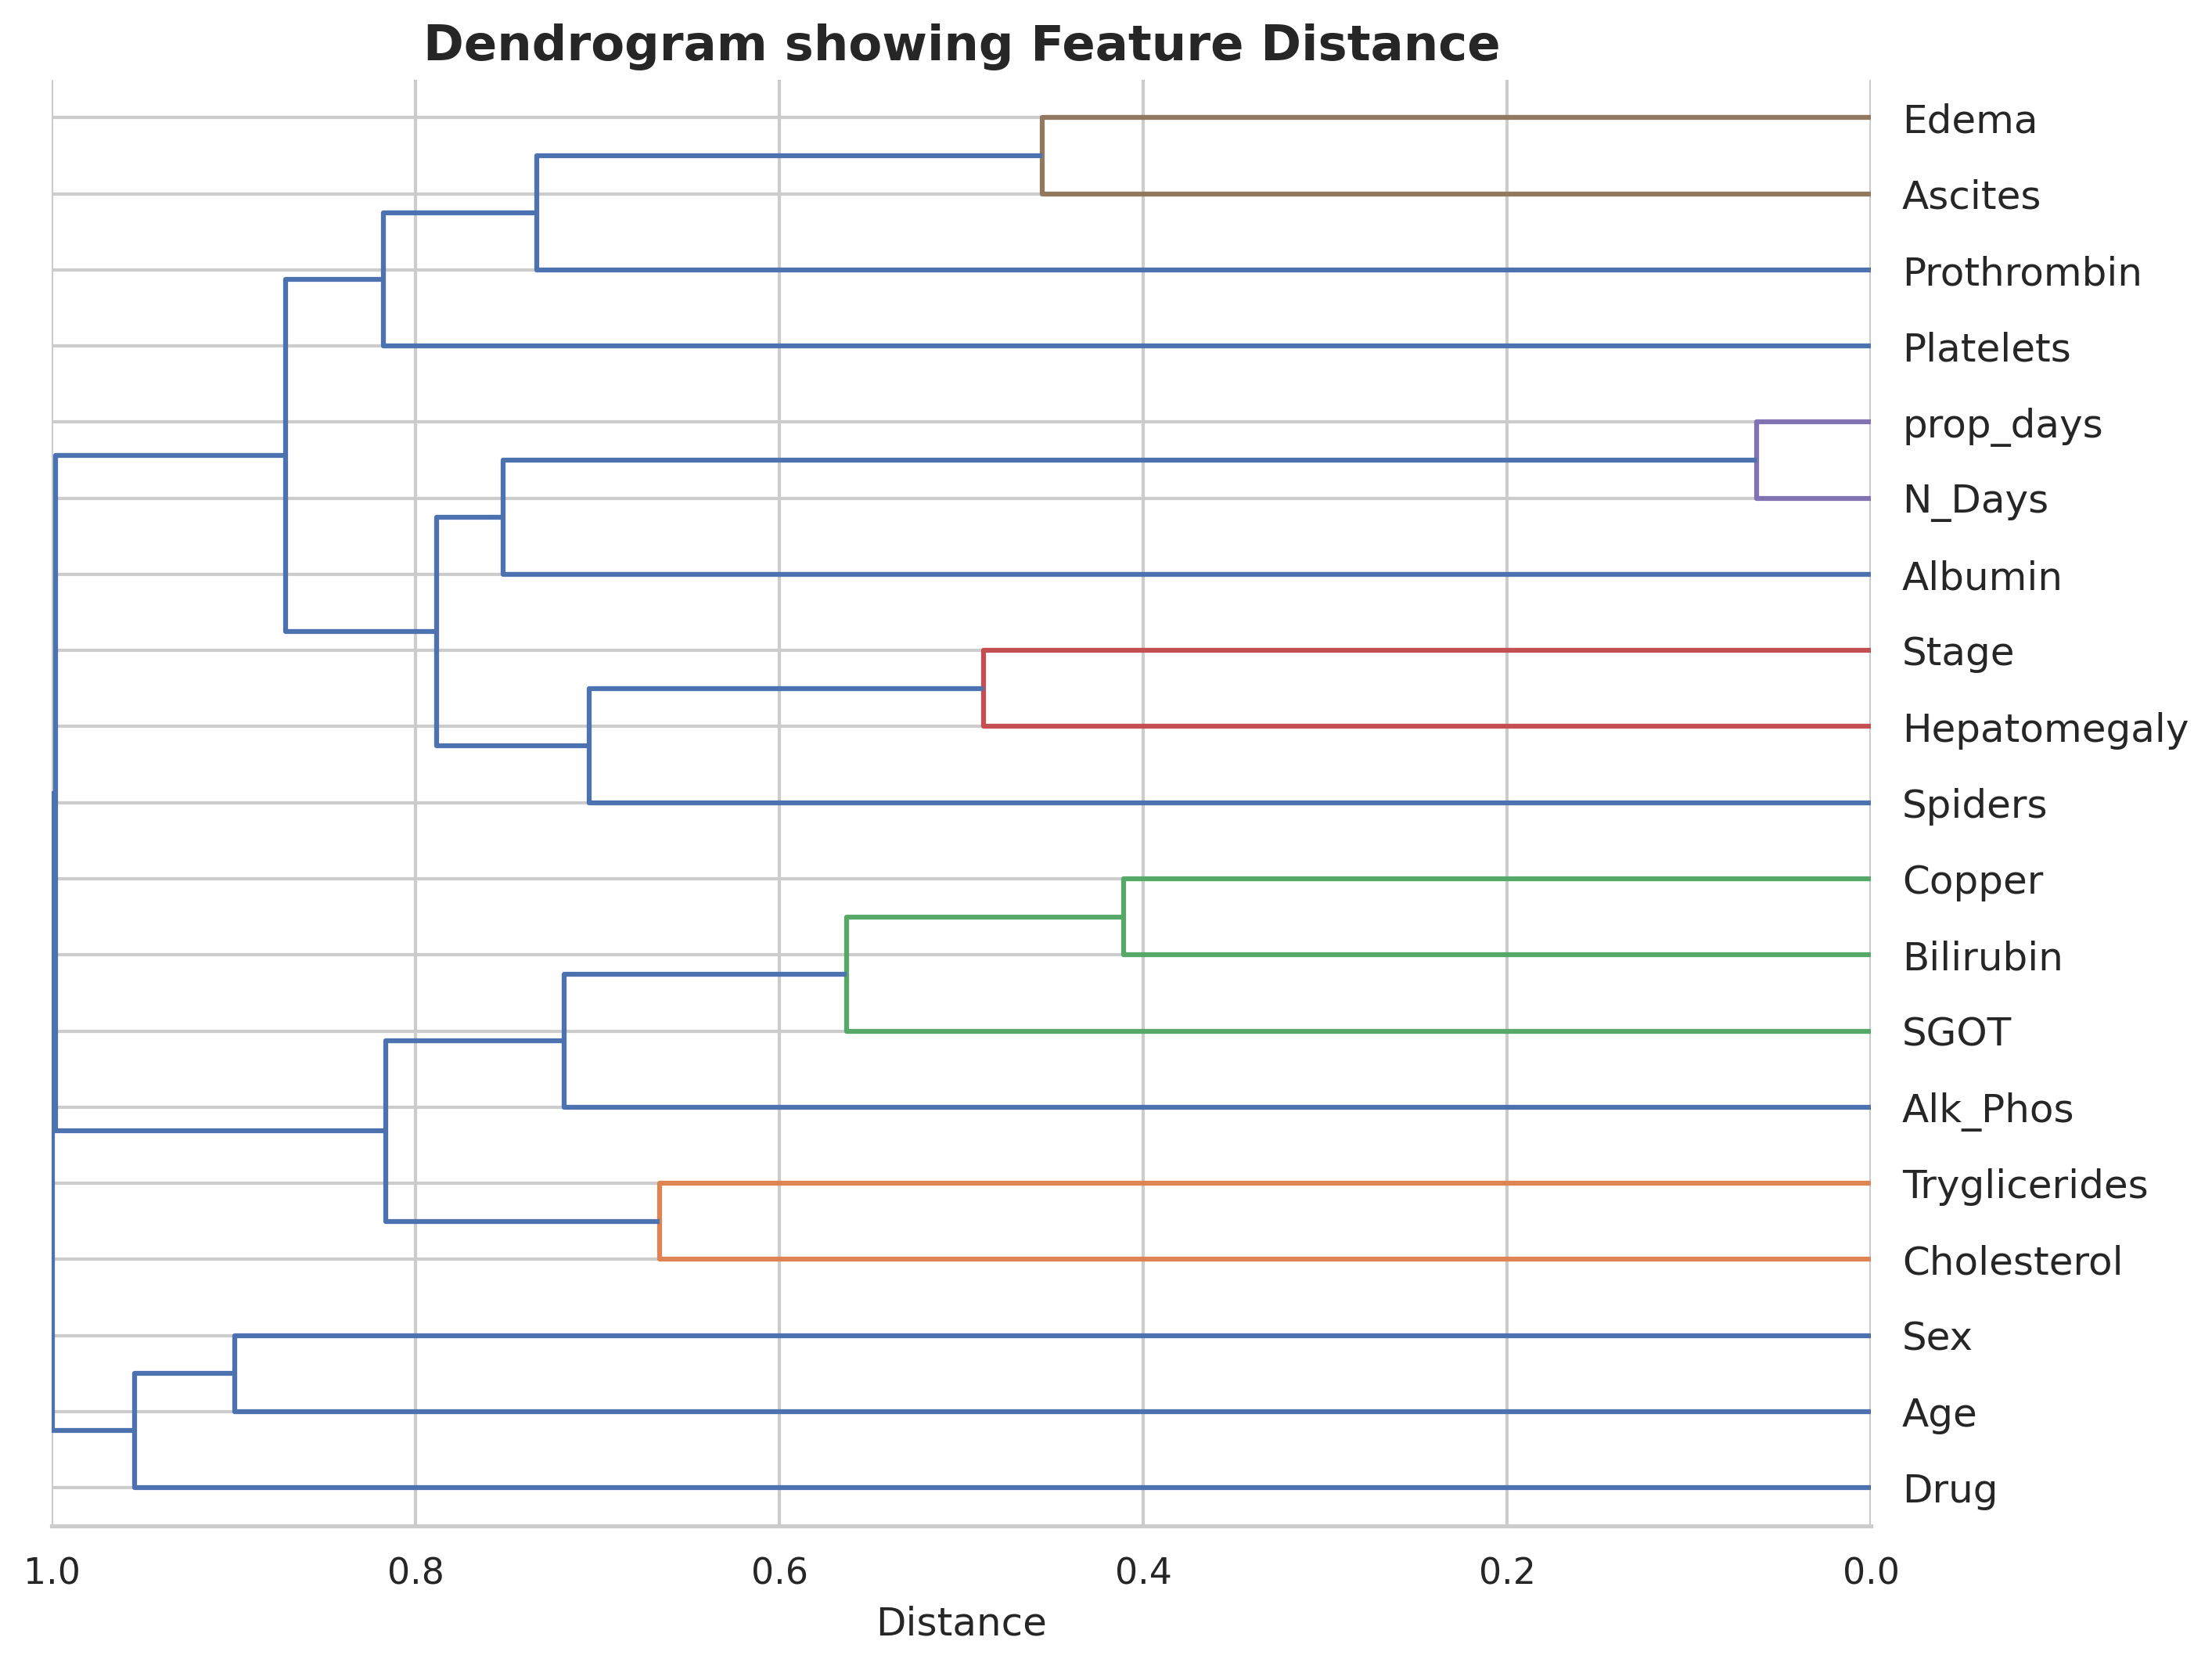

In [15]:
# I used the code for this from this notebook:
    # https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners

# Dendrogram
corr = X.corr(method='spearman')
dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

plt.figure(figsize=(10, 8), dpi=300)
dendrogram(dist_linkage, labels=X.columns, orientation='left')  # Set orientation to 'left'

plt.title('Dendrogram showing Feature Distance', weight='bold', size=15)
plt.xlabel('Distance')  # Add x-axis label
plt.xlim(1.0, 0)
sns.despine(top=True, right=True, left=True)

plt.show()

💡 **insights:** 💡
- Some of these groupings are totally expected, but others, like prop_days, N_Days, and Age, aren't.

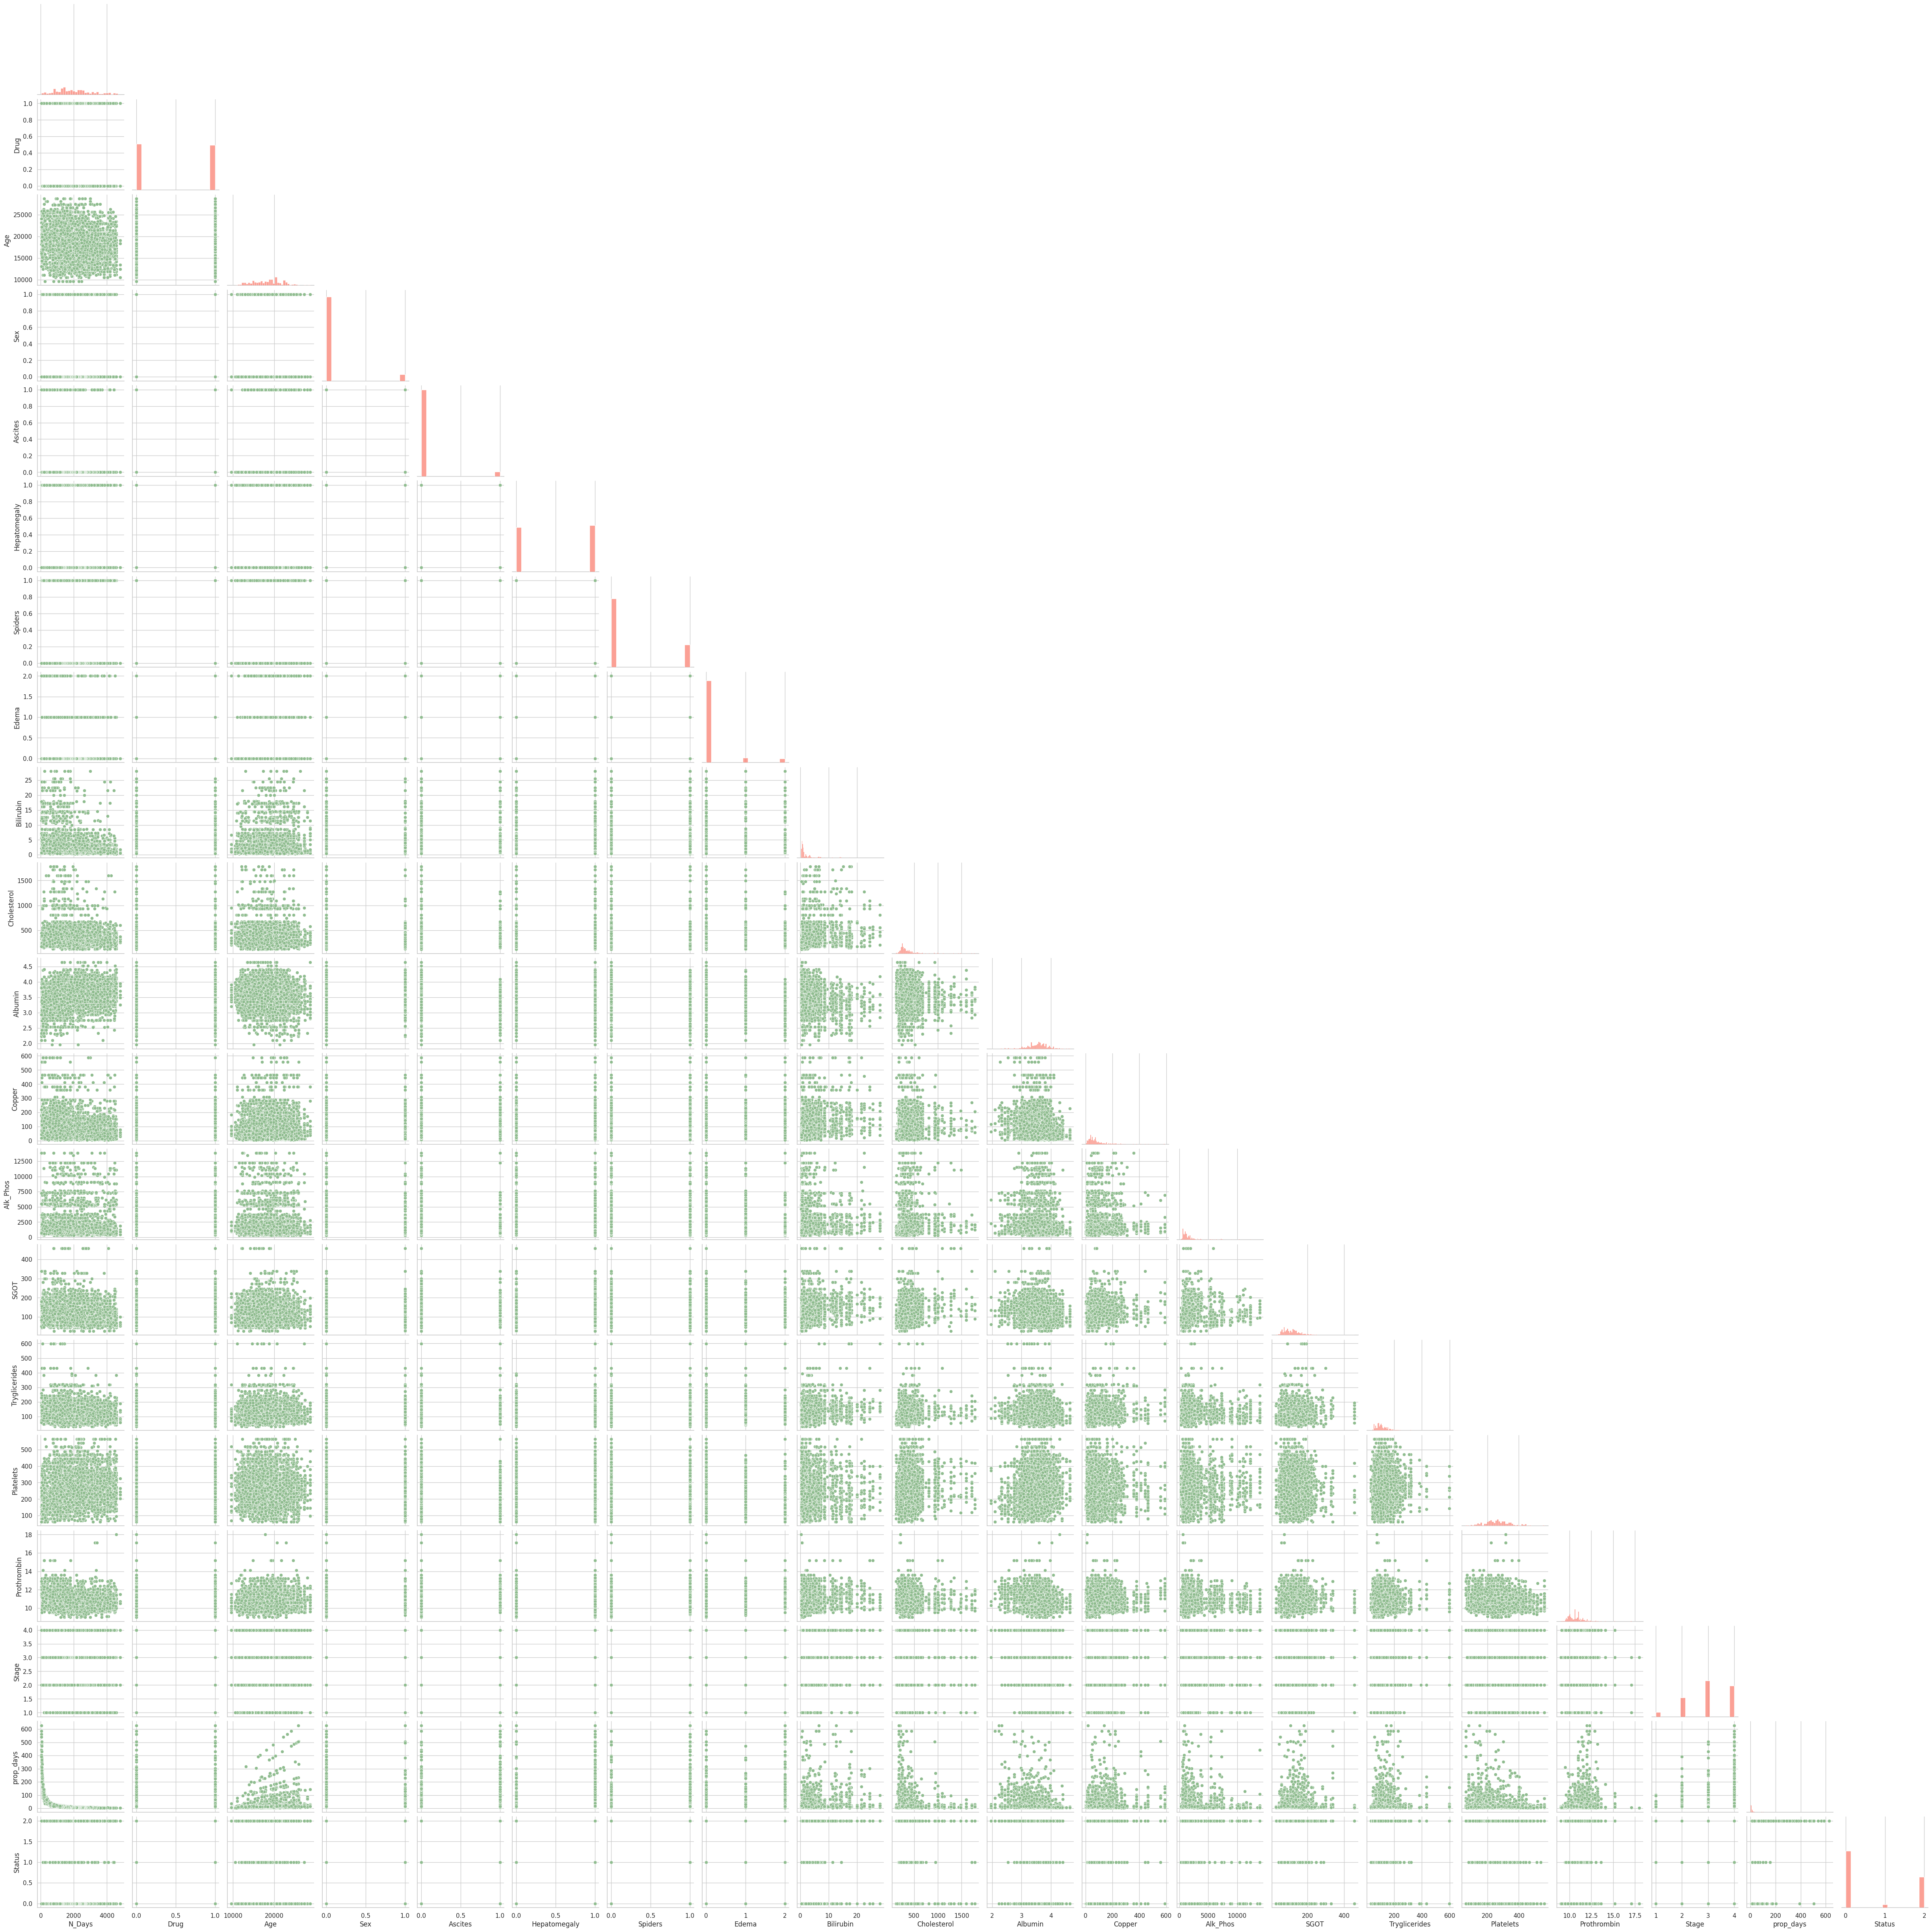

In [16]:
# Pairplot
sns.pairplot(X_plus_y, corner=True, diag_kind="hist", 
                        plot_kws={'color': 'darkseagreen'}, 
                        diag_kws={'color': 'salmon'})
plt.show()

💡 **insights:** 💡
- the prop_days feature I created looks super interesting. 
- For instance, prop-days vs Age looks like it has some sort of stratification.
- I wonder whether those groups could be teased apart either viusally with information about the label, or with some sort of unsupervised clustering algo.

In [17]:
custom_palette = ['darkseagreen', 'salmon', 'goldenrod']
# sns.pairplot(X_plus_y, corner=True, diag_kind='kde', hue='Status', palette=custom_palette)
# plt.show()

💡 **insights:** 💡
- prop_days vs N_days and prop_days vs age looks really interesting lets take a closer look

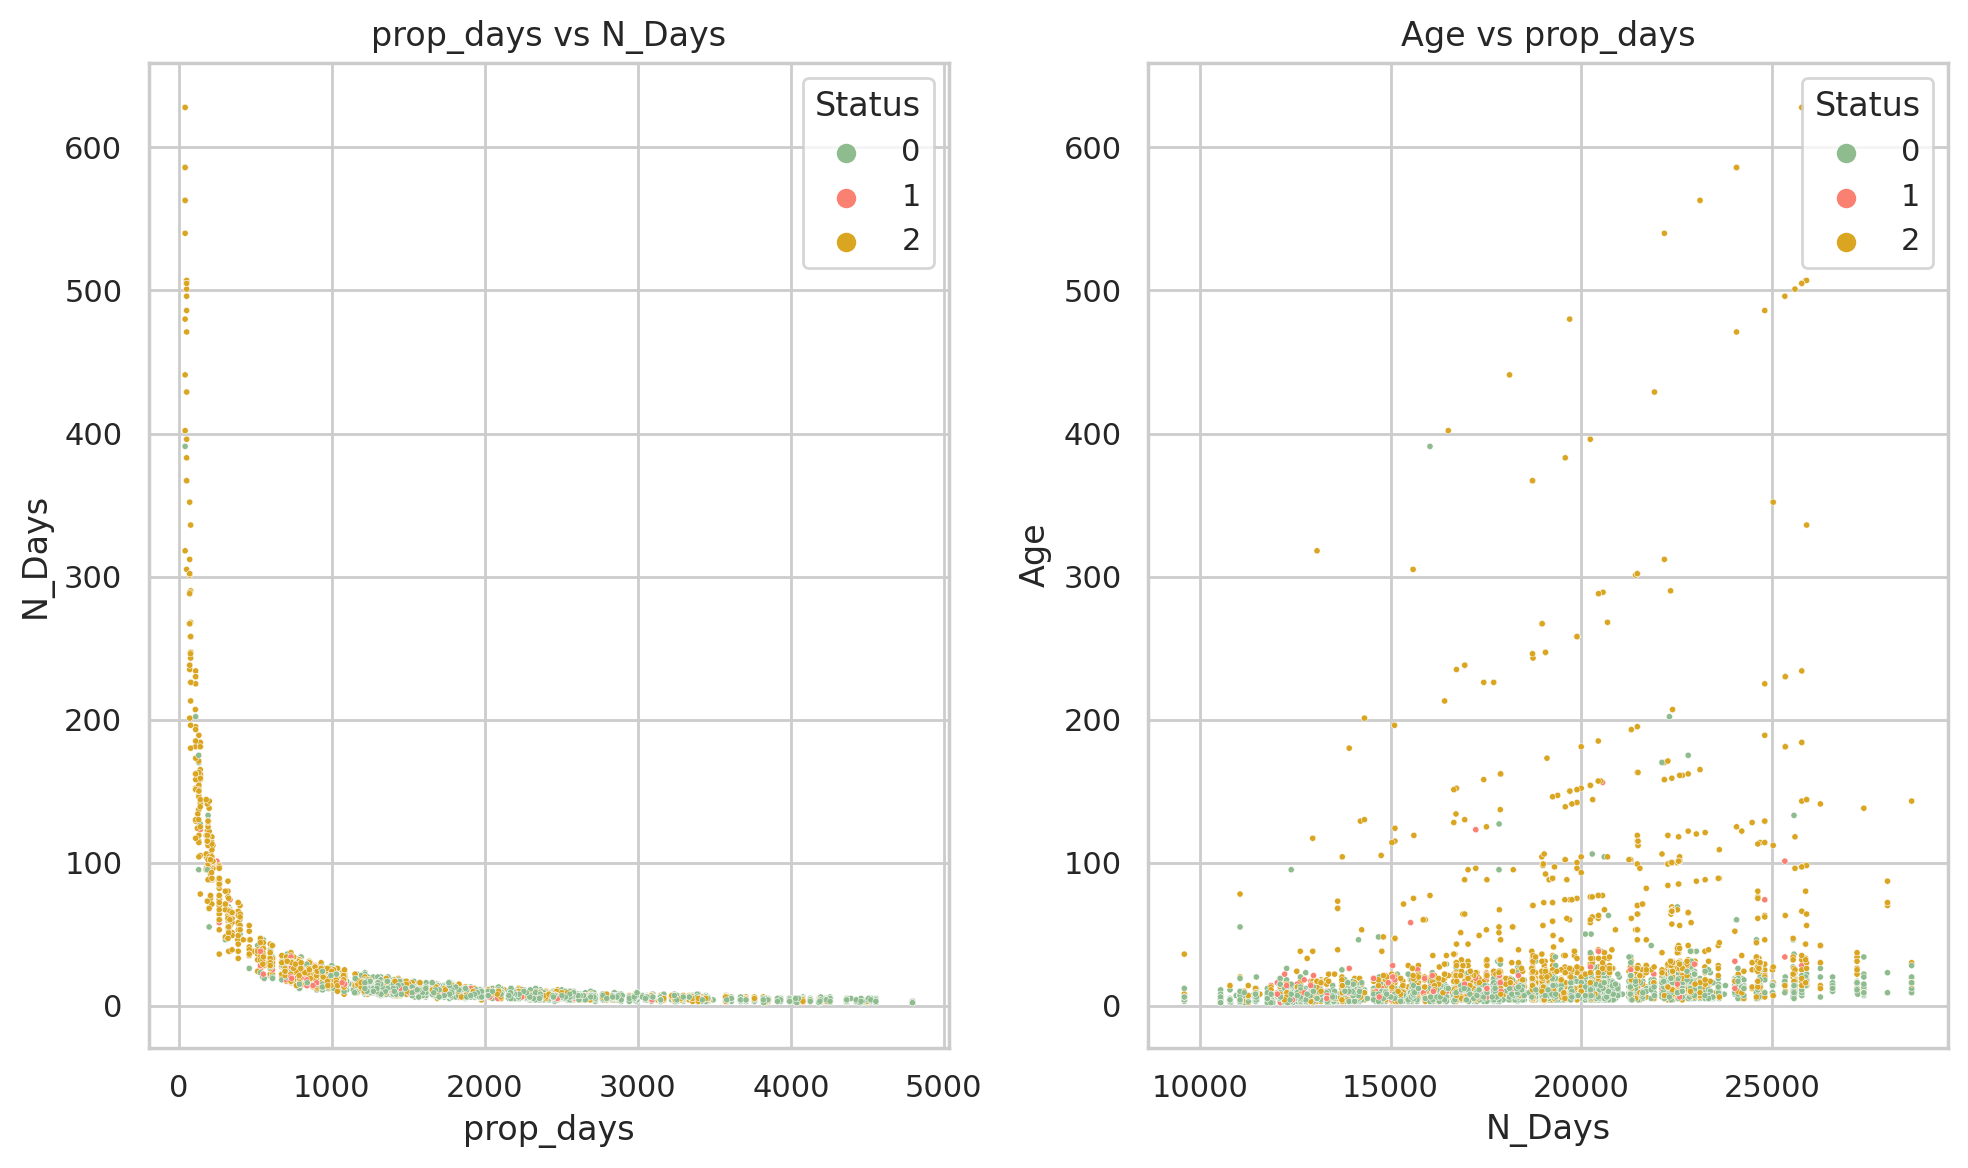

In [18]:
custom_palette = ['darkseagreen', 'salmon', 'goldenrod']
plt.figure(figsize=(10, 6), dpi=200)
plt.subplot(1, 2, 1)
sns.scatterplot(x='N_Days', y='prop_days', hue='Status', data=X_plus_y ,s=5, palette=custom_palette)
plt.xlabel('prop_days')
plt.ylabel('N_Days')
plt.title('prop_days vs N_Days')
plt.legend(title='Status')
plt.subplot(1, 2, 2)
sns.scatterplot(x='Age', y='prop_days', hue='Status', data=X_plus_y, s=5, palette=custom_palette)
plt.xlabel('N_Days')
plt.ylabel('Age')
plt.title('Age vs prop_days')
plt.legend(title='Status')
plt.tight_layout()
plt.show()

💡 **insights:** 💡
- These seem pretty easily seperable...
- I wonder if I could use a clustering algo to separate...

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Modeling with an ensemble</span>

In [19]:
def edema_remapper(df):
    df['Edema_1'] = (df['Edema'] == 0).astype(int)
    df['Edema_2'] = (df['Edema'] == 1).astype(int)
    df['Edema_3'] = (df['Edema'] == 2).astype(int)
    df['Edema2_3'] = (df['Edema_2'] | df['Edema_3']).astype(int)
    df.drop(['Edema_2', 'Edema_3'], axis=1, inplace=True)

# edema_remapper(X)
# edema_remapper(z)

In [20]:
# Modeling

# Got these params from optuna, but used train_test_split to score them
xgb_params = {'n_estimators': 800, 'max_depth': 3, 'eta': 0.1854163854377792, 
                   'gamma': 0.430245783889386, 'reg_lambda': 2.377340505093184, 'alpha': 0.025975891732692612, 
                   'min_child_weight': 1, 'colsample_bytree': 0.5491238698499994, 'subsample': 0.730216349925336}

cat_params = {'iterations': 925, 'max_depth': 5, 'learning_rate': 0.038787628344228775, 
                  'bagging_temperature': 0.11602825044808551, 'colsample_bylevel': 0.9963326742130432, 
                  'l2_leaf_reg': 1.5681799222954933, 'min_data_in_leaf': 12.41877474153627, 'max_bin': 234}

lgbm_params = {'n_estimators': 777, 'max_depth': 5, 'learning_rate': 0.12011269544570458, 
                   'num_leaves': 20, 'min_data_in_leaf': 90, 'max_bin': 225, 'lambda_l1': 0.11422455888985417, 
                   'lambda_l2': 0.21436462822502125, 'min_gain_to_split': 0.4199756997009057, 'bagging_fraction': 0.09989426137171889}

# Got these lgbm params from https://www.kaggle.com/code/satyaprakashshukl/multi-class-prediction-of-cirrhosis-outcomes
# @satyaprakashshukl
lgbm_params = {
    'max_depth': 9, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 274, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
}

XGB = XGBClassifier(random_state=SEED, 
                    objective='multi:softprob',
                    num_class=3,
                    eval_metric='mlogloss',
                    **xgb_params)

CAT = CatBoostClassifier(random_state=SEED, 
                         verbose=0, 
                         loss_function='MultiClass',
                         eval_metric='MultiClass',
                         **cat_params)

LGBM = LGBMClassifier(random_state=SEED, 
                      verbose=-1, 
                      objective='multiclass',
                      num_class=3,
                      metric='multi_logloss',
                      **lgbm_params)

voting_classifier = VotingClassifier(estimators=[('XGB', XGB), ('CAT', CAT), ('LGBM', LGBM)],
                                         n_jobs=-1,
                                         weights=[4, 9, 9],
                                         voting='soft')

voting_classifier.fit(X, y)

test_preds = voting_classifier.predict_proba(z)
print("Models completed the prediction")

Models completed the prediction


# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Submission form</span>

In [21]:
# Submission form
preds = pd.DataFrame(test_preds, columns = ['Status_C', 'Status_CL', 'Status_D'])
sub['Status_C'] = preds['Status_C']
sub['Status_CL'] = preds['Status_CL']
sub['Status_D'] = preds['Status_D']
sub.to_csv('submission.csv', index=False)
print()
print(sub.head(5))
print()
print("Submission file generated...")
print()
print("You've earned yourself a coffee...")


     id  Status_C  Status_CL  Status_D
0  7905  0.439825   0.035172  0.525003
1  7906  0.405541   0.285057  0.309402
2  7907  0.028051   0.015771  0.956178
3  7908  0.965994   0.003189  0.030817
4  7909  0.890879   0.039704  0.069417

Submission file generated...

You've earned yourself a coffee...


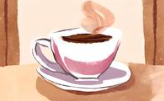